# Experimento01 Multilayer Perceptron (MLP)

## Librerías

In [4]:
# Librerias necesarias

import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from keras.initializers import Constant

from tensorflow import keras
from tensorflow.keras import layers


## Carga de conjunto de datos

In [7]:
df_training = pd.read_csv("./data/ds_training_processed.csv")
df_testing = pd.read_csv("./data/ds_testing_processed.csv")

X_train = df_training["text"]
y_train = df_training["sentiment"]
X_test = df_testing["text"]
y_test = df_testing["sentiment"]

y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

## Carga de modelos de representación

In [8]:
def load_representation_model(file_name, include_embedding_matrix=False):
    res = {}
    with open("./repmodels/"+file_name+".txt", 'r') as d:
        res["model"] = d.readline()
    res["train_text_features"] = np.load("./repmodels/"+file_name+"_train.npy")
    res["test_text_features"] = np.load("./repmodels/"+file_name+"_test.npy")

    if include_embedding_matrix:
        res["embedding_matrix"] = np.load("./repmodels/"+file_name+"_embeddingmatrix.npy")

    return res

vsm_binary = load_representation_model("vsm_binary")
vsm_binary_ngrams = load_representation_model("vsm_binary_ngrams")
vsm_tfidf = load_representation_model("vsm_tfidf")
vsm_tfidf_ngrams = load_representation_model("vsm_tfidf_ngrams")
embedding_padding = load_representation_model("embedding_padding")
embedding_glove = load_representation_model("embedding_glove", include_embedding_matrix=True)

# Cargo esto por facilidad
vsm_model = []
vsm_model.append(vsm_binary)
vsm_model.append(vsm_binary_ngrams)
vsm_model.append(vsm_tfidf)
vsm_model.append(vsm_tfidf_ngrams)

## Funciones generales

In [5]:
pd.set_option('display.max_colwidth', 2000)
vocab_size = 29773
emb_dim = 50
num_words = 29773

results = []
def add_to_results(classifier, repmodel, predict_x, y_test):
    y_pred = np.argmax(predict_x,axis=1)

    results.append({"classifier": classifier,
                    "rep.model": repmodel,
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, average="weighted"),
                    "recall": recall_score(y_test,y_pred, average="weighted")
                    })

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def nn_classification_report(predict_x, y_test, class_names):
    y_pred = np.argmax(predict_x,axis=1)

    print("Classification Report")
    print

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names))
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    plot_confusion_matrix(cm, classes=class_names)

    print("Final Accuracy")
    print(accuracy_score(y_test, y_pred))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def join_csv_for_experiment(experiment_string, number_of_experiements):
    experiments_data = []
    for i in range(1, number_of_experiements+1):
        experiments_data.append( pd.read_csv("exp_"+experiment_string+"_"+str(i)+".csv") )

    res = pd.concat(experiments_data, ignore_index=True)
    res.to_csv("exp_"+experiment_string+".csv")

## Clasificadores

In [9]:
def build_exp01(name, 
                description, 
                repmodel, 
                input_shape, 
                dense_neurons=[64], 
                dropout_layers=[None], 
                exp="Exp01",
                embedding=None):

    inputs = keras.Input(shape=input_shape, dtype="float")
    if embedding:
        x = embedding(inputs)
    else:
        x = inputs
        
    for i,_ in enumerate(dense_neurons):
        x = layers.Dense(dense_neurons[i], activation="relu")(x)
        if dropout_layers[i] is not None:
            x = layers.Dropout(dropout_layers[i])(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model._name = exp+name
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    history = model.fit(repmodel["train_text_features"].astype(float), y_train_2, 
                        epochs=40, batch_size=32,validation_split=0.2, 
                        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=7, min_delta=0.01)])
    plot_history(history)
    predict_x=model.predict(repmodel["test_text_features"].astype(float))
    nn_classification_report(predict_x, y_test, ["negative","positive"])
    add_to_results(model._name+" "+description, repmodel["model"], predict_x, y_test)

2024-04-27 15:44:58.155184: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 15:44:58.278769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 15:44:58.278994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense (Dense)               (None, 5000, 128)         256       
                                                                 
 dropout (Dropout)           (None, 5000, 128)         0         
                                                                 
 flatten (Flatten)           (None, 640000)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1280002   
                                                                 
Total params: 1280258 (4.88 MB)
Trainable params: 1280258 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


L355
2024-04-27 15:44:58.280488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 15:44:58.280647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 15:44:58.355696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

None
Epoch 1/40


2024-04-27 15:45:00.189979: I external/local_xla/xla/service/service.cc:168] XLA service 0x732a3dbb8860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-27 15:45:00.190007: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-27 15:45:00.194529: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-27 15:45:00.210819: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1714225500.262664  410497 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 3s 5ms/step - loss: 0.4783 - accuracy: 0.7733 - val_loss: 0.5183 - val_accuracy: 0.7164
Epoch 2/40
250/250 [==============================] - 1s 4ms/step - loss: 0.2289 - accuracy: 0.9151 - val_loss: 0.7239 - val_accuracy: 0.6253
Epoch 3/40
250/250 [==============================] - 1s 4ms/step - loss: 0.1346 - accuracy: 0.9566 - val_loss: 0.3329 - val_accuracy: 0.8424
Epoch 4/40
250/250 [==============================] - 1s 4ms/step - loss: 0.0994 - accuracy: 0.9676 - val_loss: 0.3612 - val_accuracy: 0.8349
Epoch 5/40
250/250 [==============================] - 1s 4ms/step - loss: 0.0745 - accuracy: 0.9779 - val_loss: 0.8518 - val_accuracy: 0.7014
Epoch 6/40
250/250 [==============================] - 1s 4ms/step - loss: 0.0683 - accuracy: 0.9800 - val_loss: 0.5669 - val_accuracy: 0.7984
Epoch 7/40
250/250 [==============================] - 1s 4ms/step - loss: 0.0542 - accuracy: 0.9829 - val_loss: 0.6806 - val_accuracy: 0.7704
Epoch 8/40
250/25

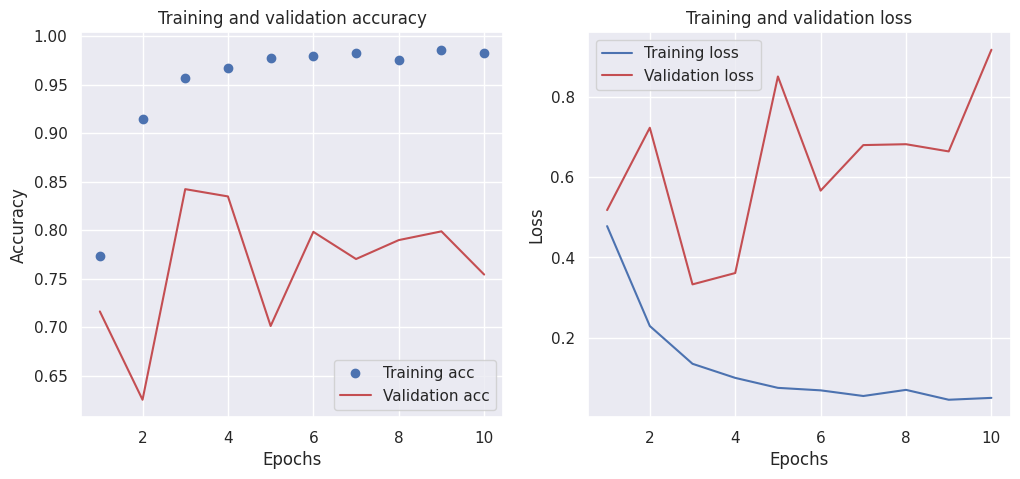

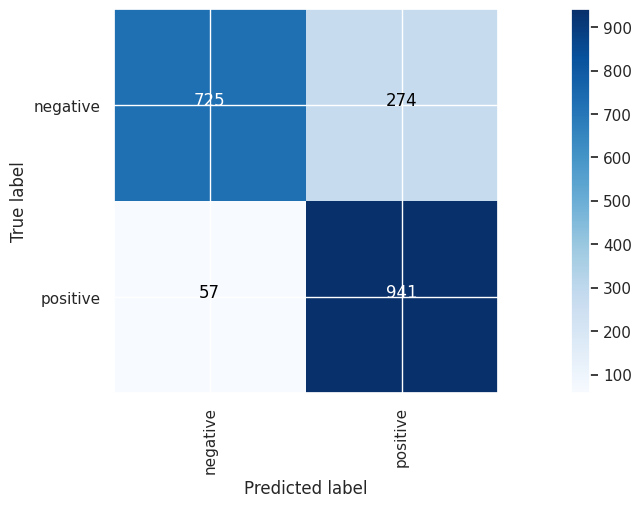

Final Accuracy
0.8342513770655984
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense_2 (Dense)             (None, 5000, 128)         256       
                                                                 
 dropout_1 (Dropout)         (None, 5000, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 640000)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1280002   
                                                                 
Total params: 1280258 (4.88 MB)
Trainable params: 1280258 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________________

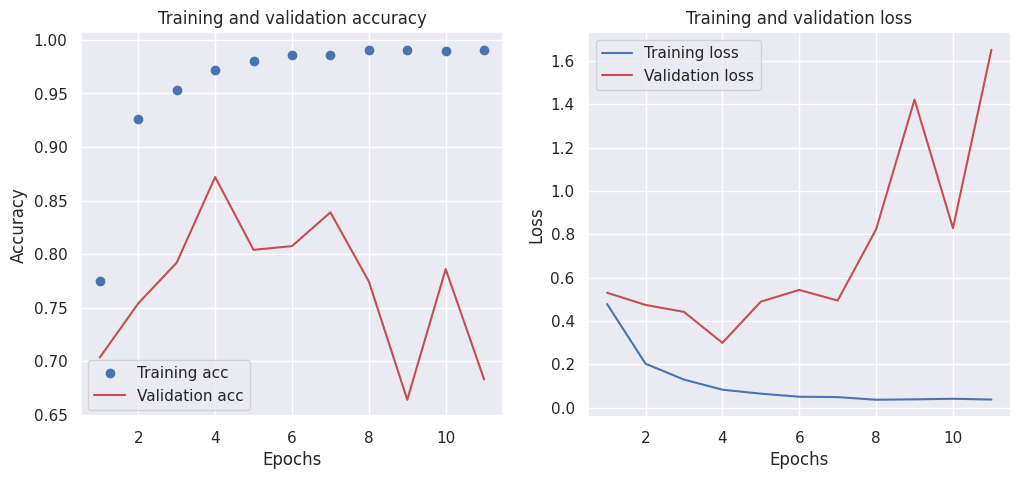

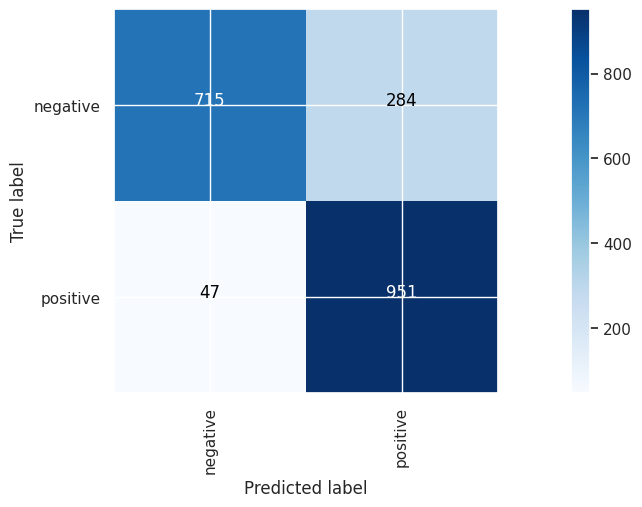

Final Accuracy
0.8342513770655984
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense_4 (Dense)             (None, 5000, 128)         256       
                                                                 
 dropout_2 (Dropout)         (None, 5000, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 640000)            0         
                                                                 
 dense_5 (Dense)             (None, 2)                 1280002   
                                                                 
Total params: 1280258 (4.88 MB)
Trainable params: 1280258 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________________

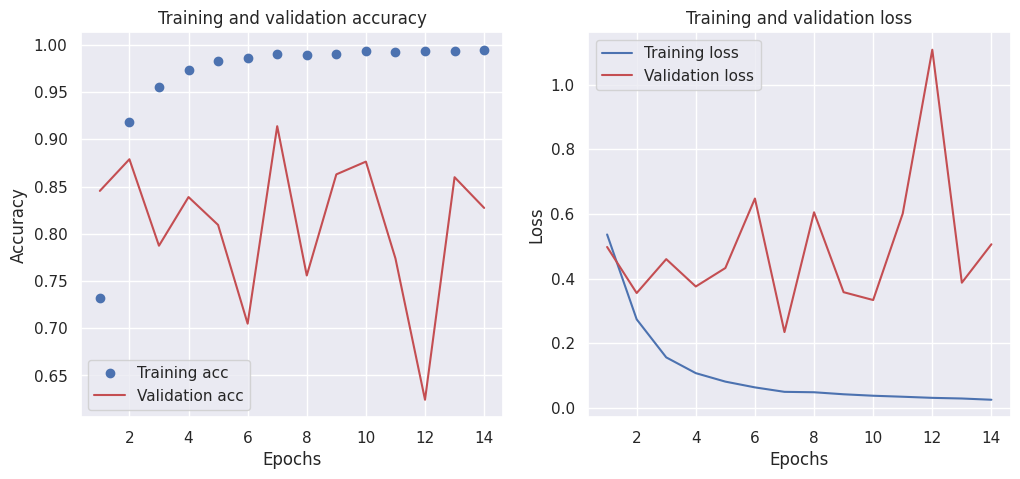

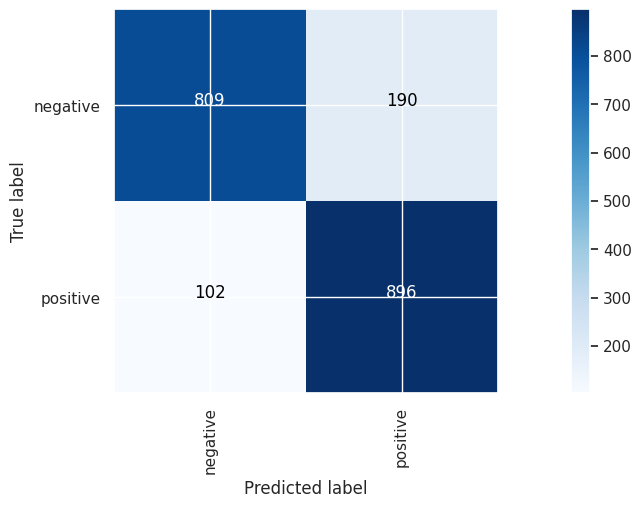

Final Accuracy
0.8537806710065098
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense_6 (Dense)             (None, 5000, 128)         256       
                                                                 
 dropout_3 (Dropout)         (None, 5000, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 640000)            0         
                                                                 
 dense_7 (Dense)             (None, 2)                 1280002   
                                                                 
Total params: 1280258 (4.88 MB)
Trainable params: 1280258 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________________

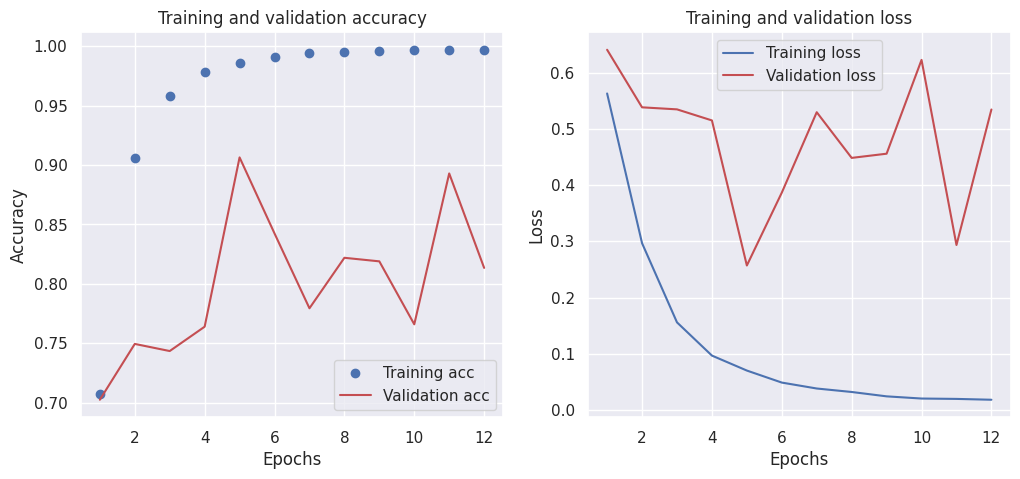

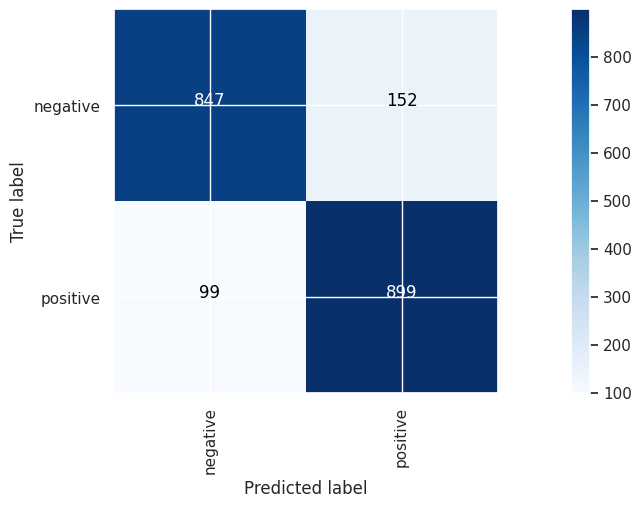

Final Accuracy
0.8743114672008012


In [10]:
# VSM models
results = []
for rep in vsm_model:
    build_exp01("MLP",
                "dense_neurons=[128], dropout_layers=[0.5]", 
                rep, 
                dense_neurons=[128],
                dropout_layers=[0.5], 
                input_shape=(5000,1,))
partial = pd.DataFrame(results)
partial.to_csv("exp_01_1.csv", index=False)

Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(32, 600)]               0         
                                                                 
 embedding_3 (Embedding)     (32, 600, 50)             1488650   
                                                                 
 dense_4 (Dense)             (32, 600, 128)            6528      
                                                                 
 dropout_2 (Dropout)         (32, 600, 128)            0         
                                                                 
 flatten_2 (Flatten)         (32, 76800)               0         
                                                                 
 dense_5 (Dense)             (32, 2)                   153602    
                                                                 
Total params: 1648780 (6.29 MB)
Trainable params: 1648780 

2024-04-26 14:50:32.021767: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbe438d0320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 14:50:32.021795: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-26 14:50:32.029704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-26 14:50:32.049260: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1714135832.103445    5305 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 24s 89ms/step - loss: 0.4266 - accuracy: 0.8009 - val_loss: 0.3469 - val_accuracy: 0.8244
Epoch 2/40
250/250 [==============================] - 17s 69ms/step - loss: 0.1354 - accuracy: 0.9482 - val_loss: 0.3004 - val_accuracy: 0.8624
Epoch 3/40
250/250 [==============================] - 12s 46ms/step - loss: 0.0740 - accuracy: 0.9767 - val_loss: 0.3410 - val_accuracy: 0.8644
Epoch 4/40
250/250 [==============================] - 9s 35ms/step - loss: 0.0473 - accuracy: 0.9855 - val_loss: 0.3765 - val_accuracy: 0.8649
Epoch 5/40
250/250 [==============================] - 8s 32ms/step - loss: 0.0345 - accuracy: 0.9892 - val_loss: 0.5538 - val_accuracy: 0.8354
Epoch 6/40
250/250 [==============================] - 7s 29ms/step - loss: 0.0267 - accuracy: 0.9921 - val_loss: 0.5531 - val_accuracy: 0.8484
Epoch 7/40
250/250 [==============================] - 5s 20ms/step - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.7223 - val_accuracy: 0.8314
Epoch 8

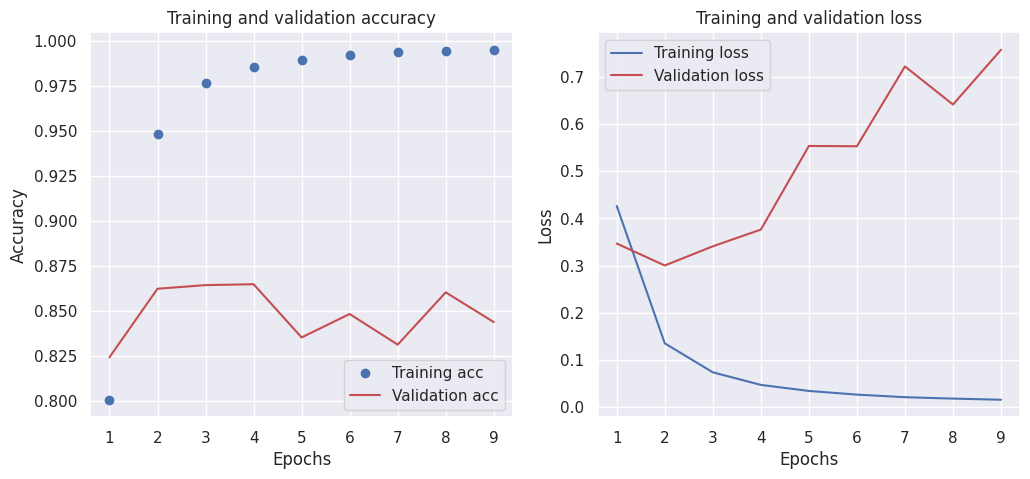

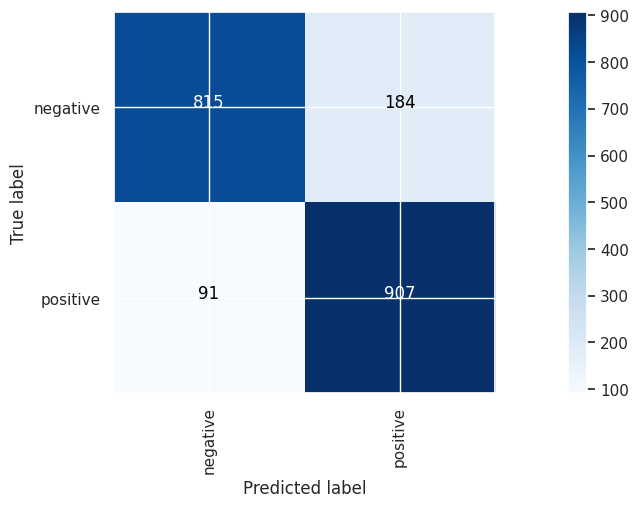

Final Accuracy
0.8622934401602403


In [10]:
# Embedding with padding
results = []
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp01("MLP",
            "dense_neurons=[128], dropout_layers=[0.5]", 
            embedding_padding, 
            dense_neurons=[128],
            dropout_layers=[0.5], 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding
            )

Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_2 (Dense)             (None, 600, 128)          6528      
                                                                 
 dropout_1 (Dropout)         (None, 600, 128)          0         
                                                                 
 flatten_1 (Flatten)         (None, 76800)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 153602    
                                                                 
Total params: 1648780 (6.29 MB)
Trainable params: 1648780 

None
Epoch 1/40


2024-04-26 16:32:38.585021: I external/local_xla/xla/service/service.cc:168] XLA service 0x756da4a88150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 16:32:38.585062: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-26 16:32:38.593758: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-26 16:32:38.616735: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1714141958.673046   35904 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 24s 90ms/step - loss: 0.5294 - accuracy: 0.7497 - val_loss: 0.4764 - val_accuracy: 0.7414
Epoch 2/40
250/250 [==============================] - 16s 65ms/step - loss: 0.2702 - accuracy: 0.8928 - val_loss: 0.4320 - val_accuracy: 0.7954
Epoch 3/40
250/250 [==============================] - 12s 47ms/step - loss: 0.1794 - accuracy: 0.9323 - val_loss: 0.5669 - val_accuracy: 0.7574
Epoch 4/40
250/250 [==============================] - 9s 36ms/step - loss: 0.1301 - accuracy: 0.9532 - val_loss: 0.4532 - val_accuracy: 0.8134
Epoch 5/40
250/250 [==============================] - 8s 31ms/step - loss: 0.0976 - accuracy: 0.9685 - val_loss: 0.3022 - val_accuracy: 0.8774
Epoch 6/40
250/250 [==============================] - 7s 27ms/step - loss: 0.0797 - accuracy: 0.9730 - val_loss: 0.4224 - val_accuracy: 0.8394
Epoch 7/40
250/250 [==============================] - 5s 18ms/step - loss: 0.0629 - accuracy: 0.9797 - val_loss: 0.3711 - val_accuracy: 0.8679
Epoch 8

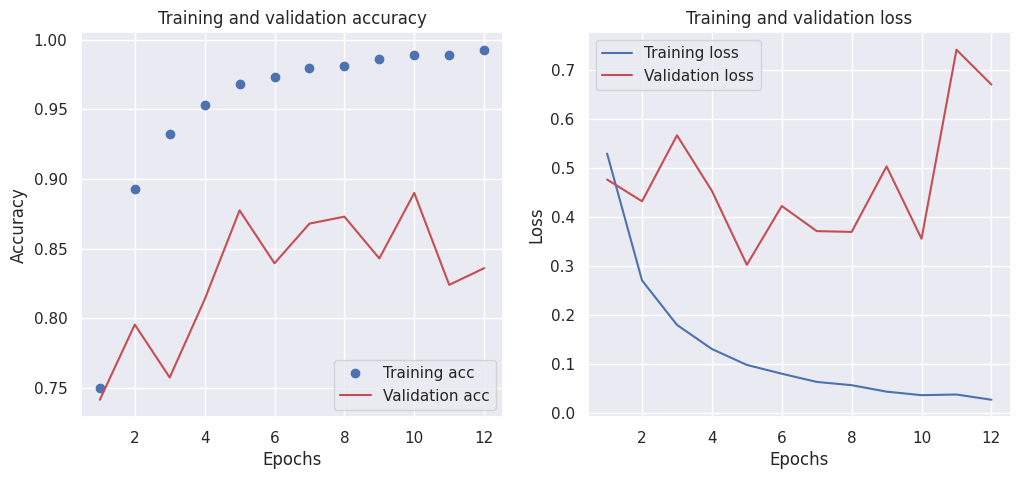

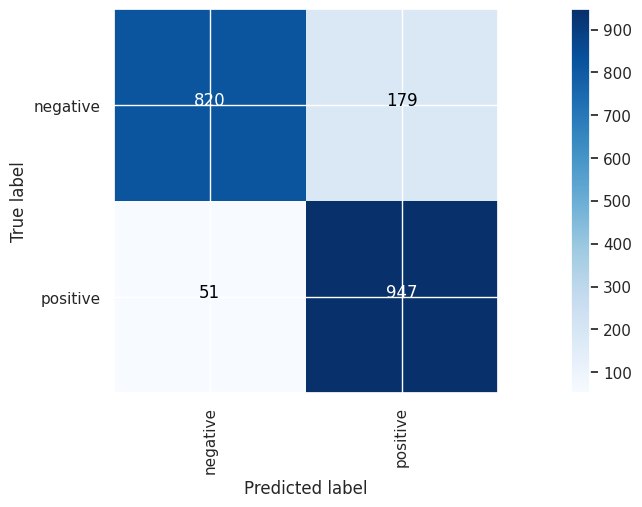

Final Accuracy
0.8848272408612919


In [7]:
# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp01("MLP",
            "dense_neurons=[128], dropout_layers=[0.5]", 
            embedding_glove, 
            dense_neurons=[128],
            dropout_layers=[0.5], 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_01_2.csv", index=False)

Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense_4 (Dense)             (None, 5000, 64)          128       
                                                                 
 dropout_2 (Dropout)         (None, 5000, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 320000)            0         
                                                                 
 dense_5 (Dense)             (None, 2)                 640002    
                                                                 
Total params: 640130 (2.44 MB)
Trainable params: 640130 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/25

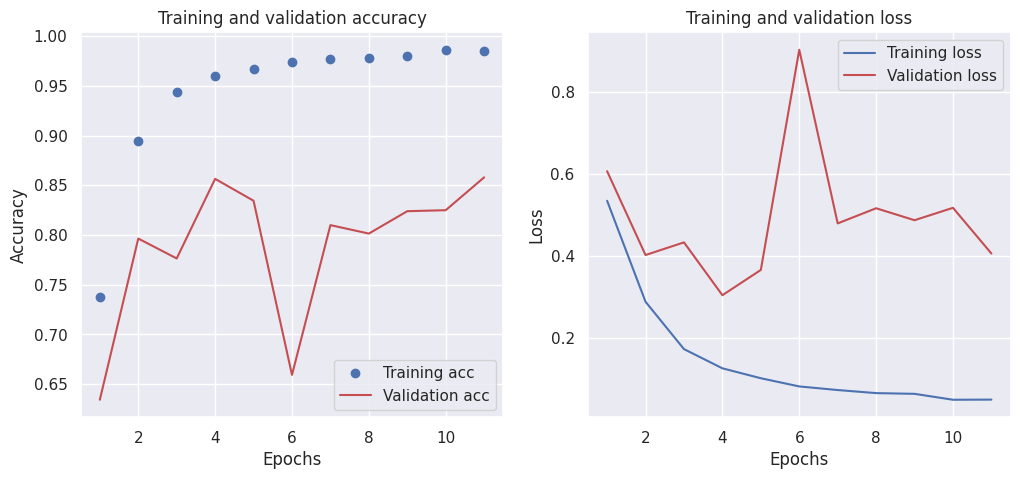

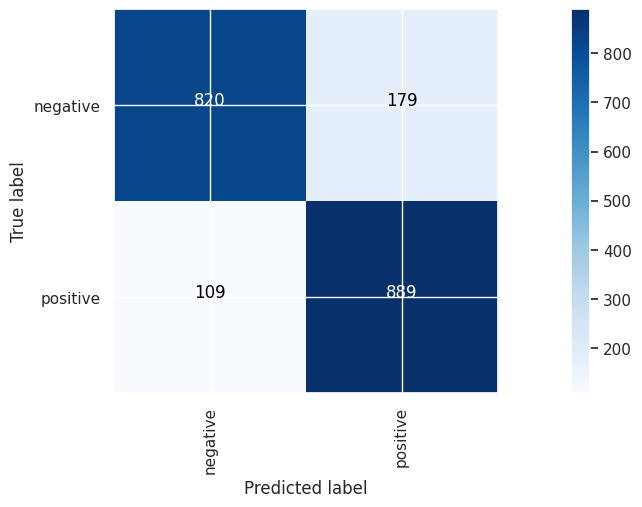

Final Accuracy
0.85578367551327
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense_6 (Dense)             (None, 5000, 64)          128       
                                                                 
 dropout_3 (Dropout)         (None, 5000, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 320000)            0         
                                                                 
 dense_7 (Dense)             (None, 2)                 640002    
                                                                 
Total params: 640130 (2.44 MB)
Trainable params: 640130 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________

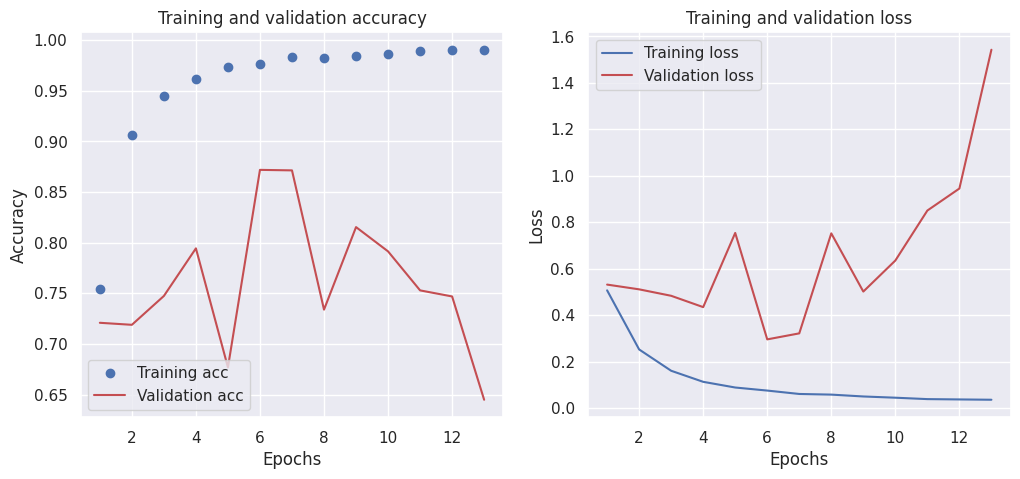

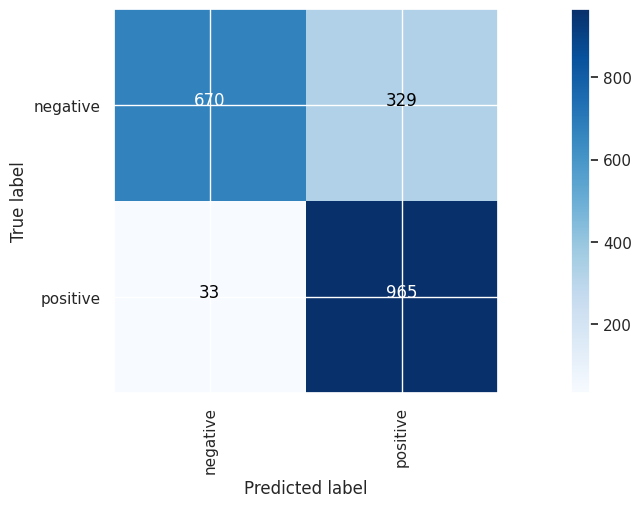

Final Accuracy
0.8187280921382073
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense_8 (Dense)             (None, 5000, 64)          128       
                                                                 
 dropout_4 (Dropout)         (None, 5000, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 320000)            0         
                                                                 
 dense_9 (Dense)             (None, 2)                 640002    
                                                                 
Total params: 640130 (2.44 MB)
Trainable params: 640130 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________

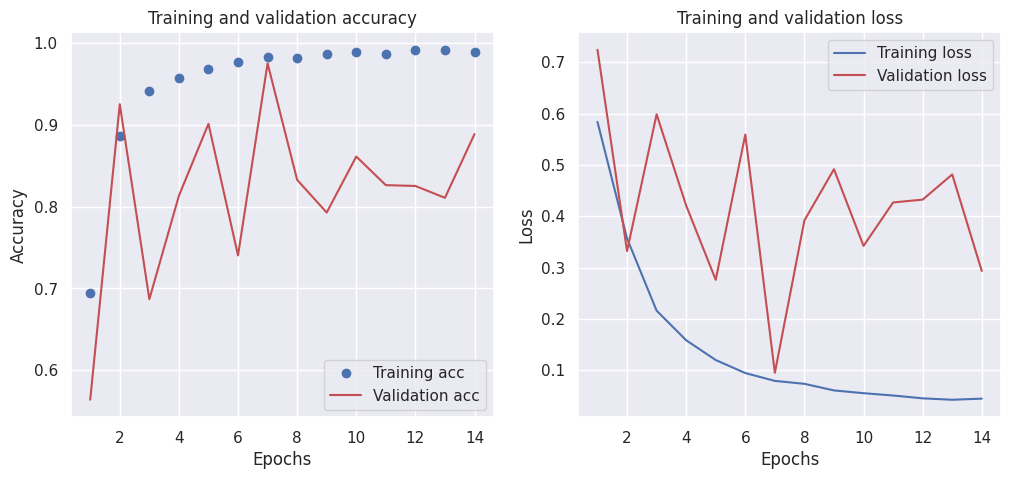

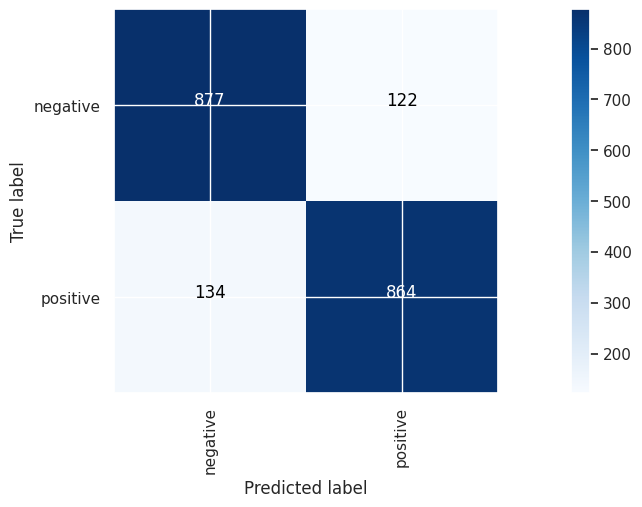

Final Accuracy
0.871807711567351
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense_10 (Dense)            (None, 5000, 64)          128       
                                                                 
 dropout_5 (Dropout)         (None, 5000, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 320000)            0         
                                                                 
 dense_11 (Dense)            (None, 2)                 640002    
                                                                 
Total params: 640130 (2.44 MB)
Trainable params: 640130 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________

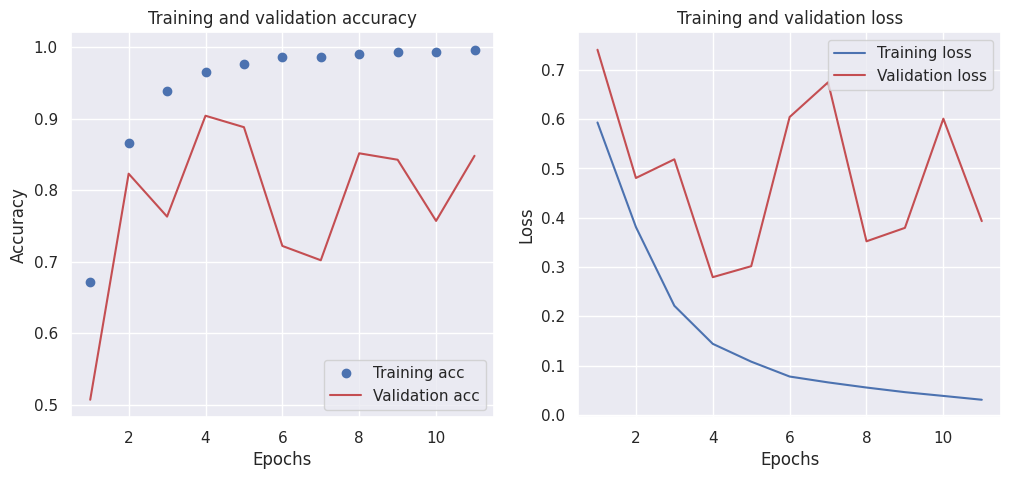

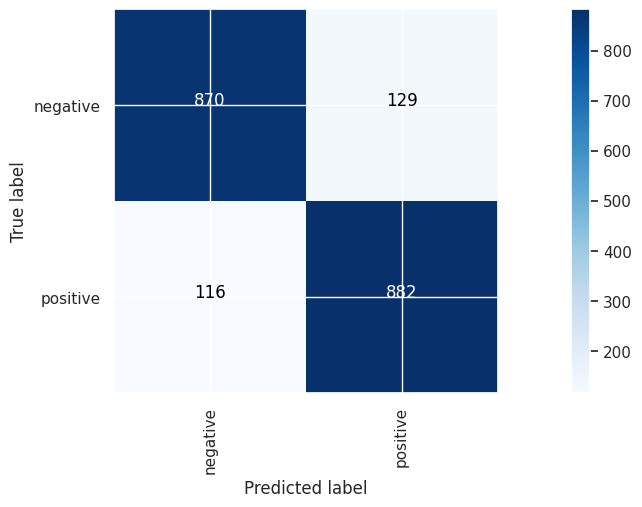

Final Accuracy
0.8773159739609414
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_12 (Dense)            (None, 600, 64)           3264      
                                                                 
 dropout_6 (Dropout)         (None, 600, 64)           0         
                                                                 
 flatten_6 (Flatten)         (None, 38400)             0         
                                                                 
 dense_13 (Dense)            (None, 2)                 76802     
                                                                 
Total params: 1568716 (5

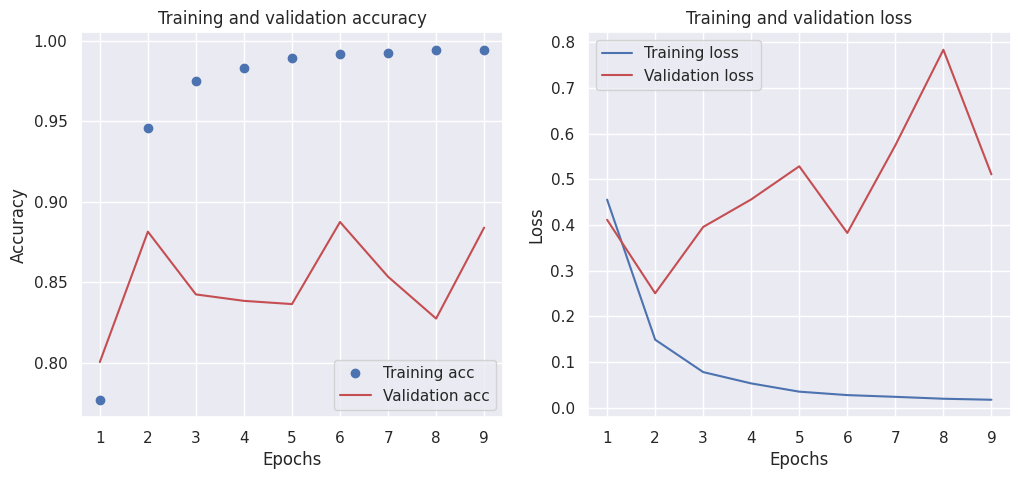

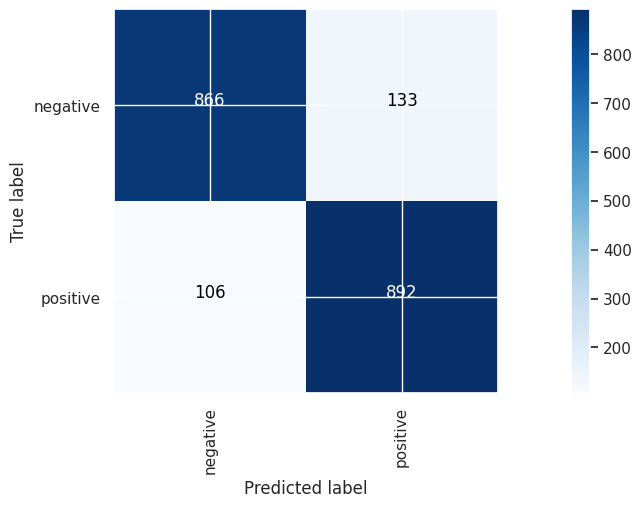

Final Accuracy
0.8803204807210816
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_14 (Dense)            (None, 600, 64)           3264      
                                                                 
 dropout_7 (Dropout)         (None, 600, 64)           0         
                                                                 
 flatten_7 (Flatten)         (None, 38400)             0         
                                                                 
 dense_15 (Dense)            (None, 2)                 76802     
                                                                 
Total params: 1568716 (5

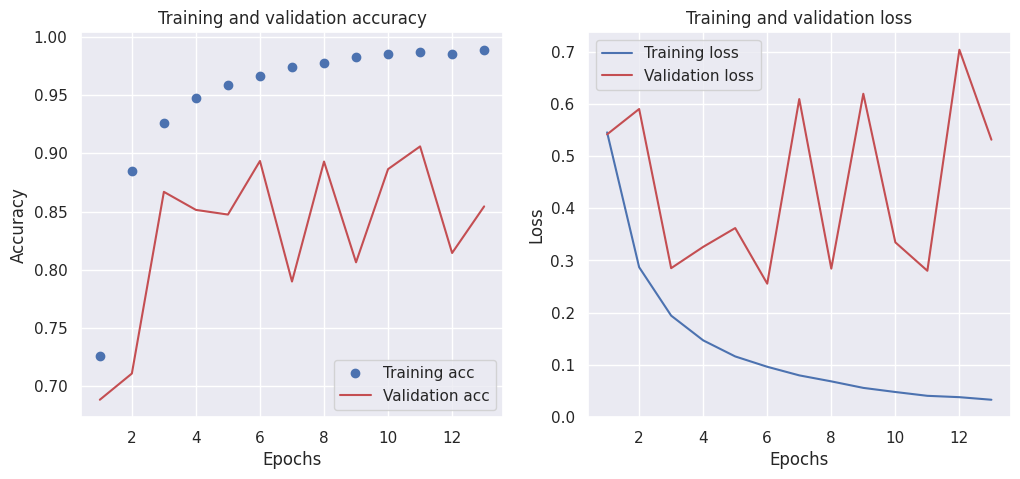

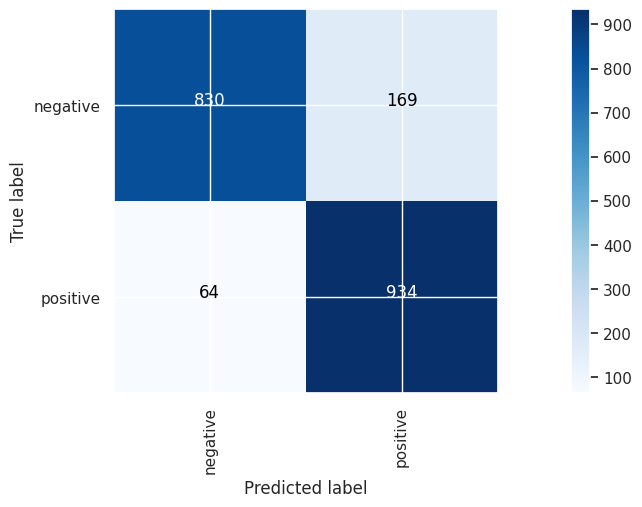

Final Accuracy
0.8833249874812218


In [11]:
# VSM models
results = []
for rep in vsm_model:
    build_exp01("MLP",
                "dense_neurons=[64], dropout_layers=[0.5]", 
                rep, 
                dense_neurons=[64],
                dropout_layers=[0.5], 
                input_shape=(5000,1,))

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp01("MLP",
            "dense_neurons=[64], dropout_layers=[0.5]", 
            embedding_padding, 
            dense_neurons=[64],
            dropout_layers=[0.5], 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp01("MLP",
            "dense_neurons=[64], dropout_layers=[0.5]", 
            embedding_glove, 
            dense_neurons=[64],
            dropout_layers=[0.5], 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_01_3.csv", index=False)

Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 dense_16 (Dense)            (None, 5000, 32)          64        
                                                                 
 dropout_8 (Dropout)         (None, 5000, 32)          0         
                                                                 
 flatten_8 (Flatten)         (None, 160000)            0         
                                                                 
 dense_17 (Dense)            (None, 2)                 320002    
                                                                 
Total params: 320066 (1.22 MB)
Trainable params: 320066 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/25

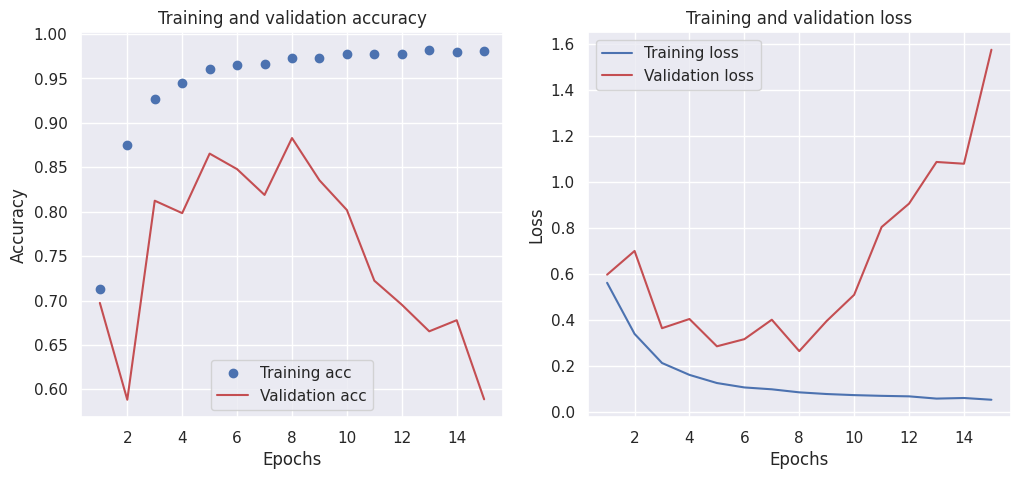

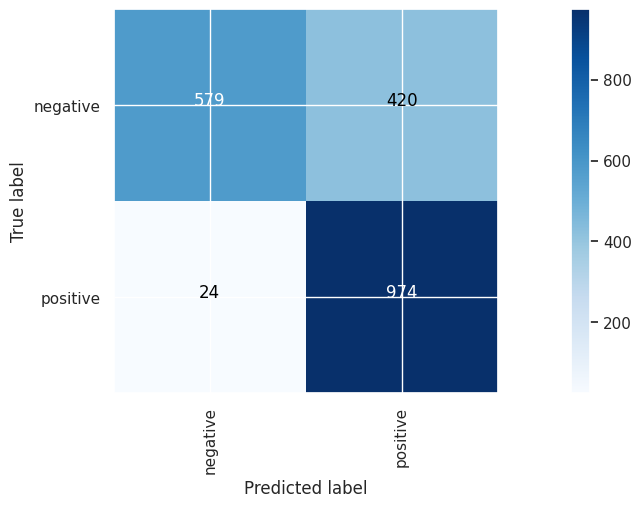

Final Accuracy
0.7776664997496244
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_18 (Dense)            (None, 5000, 32)          64        
                                                                 
 dropout_9 (Dropout)         (None, 5000, 32)          0         
                                                                 
 flatten_9 (Flatten)         (None, 160000)            0         
                                                                 
 dense_19 (Dense)            (None, 2)                 320002    
                                                                 
Total params: 320066 (1.22 MB)
Trainable params: 320066 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________

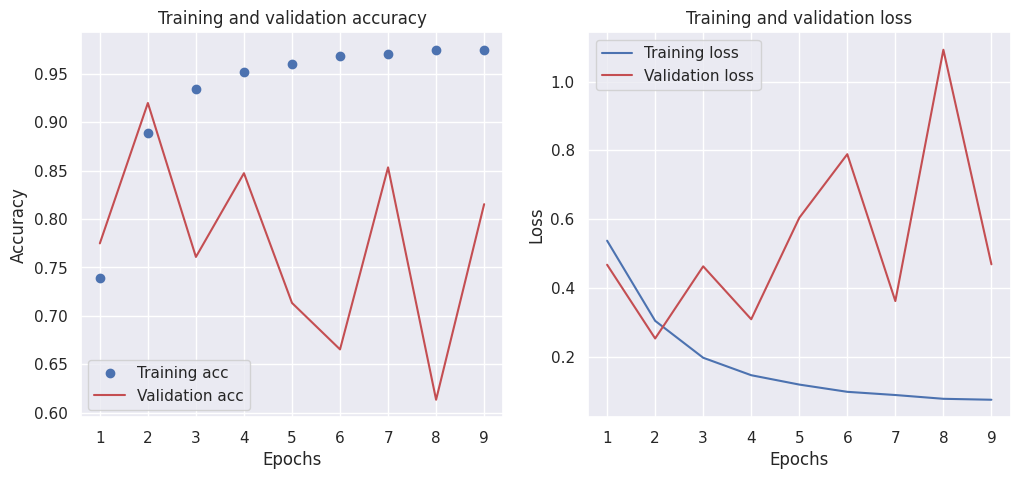

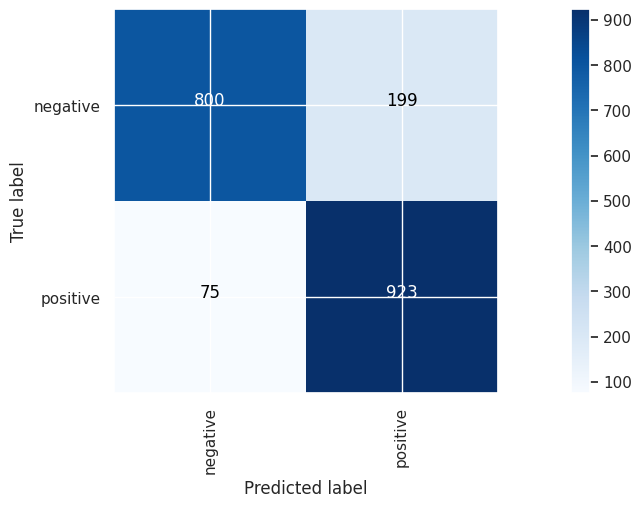

Final Accuracy
0.8627941912869304
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_20 (Dense)            (None, 5000, 32)          64        
                                                                 
 dropout_10 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_10 (Flatten)        (None, 160000)            0         
                                                                 
 dense_21 (Dense)            (None, 2)                 320002    
                                                                 
Total params: 320066 (1.22 MB)
Trainable params: 320066 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________

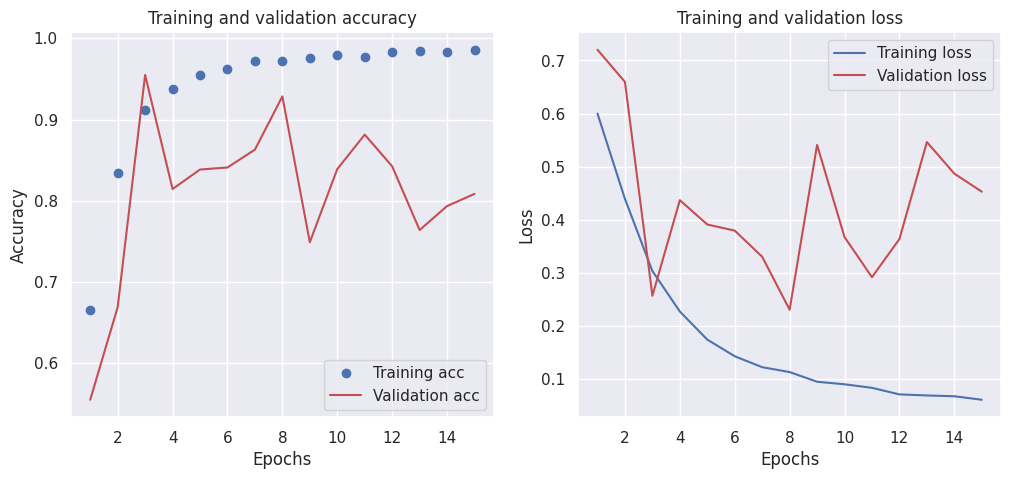

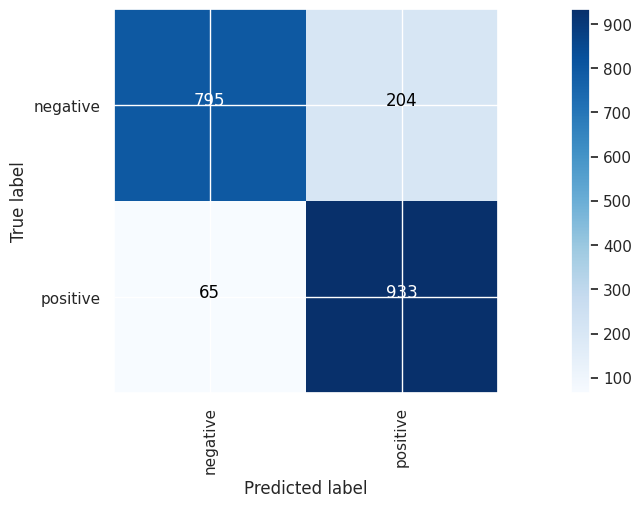

Final Accuracy
0.8652979469203805
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_22 (Dense)            (None, 5000, 32)          64        
                                                                 
 dropout_11 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_11 (Flatten)        (None, 160000)            0         
                                                                 
 dense_23 (Dense)            (None, 2)                 320002    
                                                                 
Total params: 320066 (1.22 MB)
Trainable params: 320066 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________

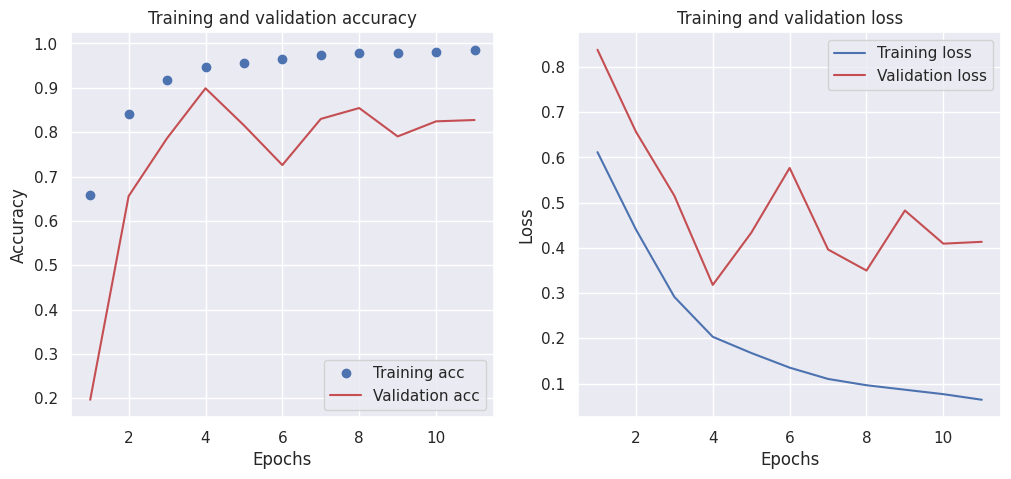

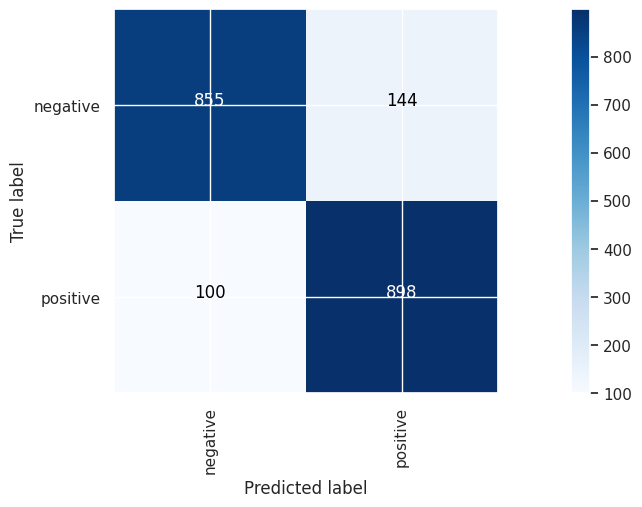

Final Accuracy
0.8778167250876314
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_24 (Dense)            (None, 600, 32)           1632      
                                                                 
 dropout_12 (Dropout)        (None, 600, 32)           0         
                                                                 
 flatten_12 (Flatten)        (None, 19200)             0         
                                                                 
 dense_25 (Dense)            (None, 2)                 38402     
                                                                 
Total params: 1528684 (5

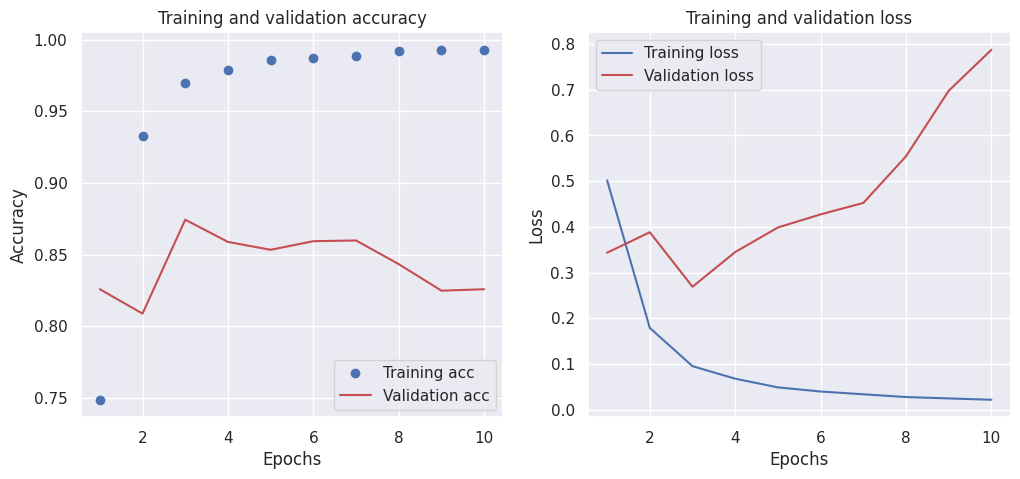

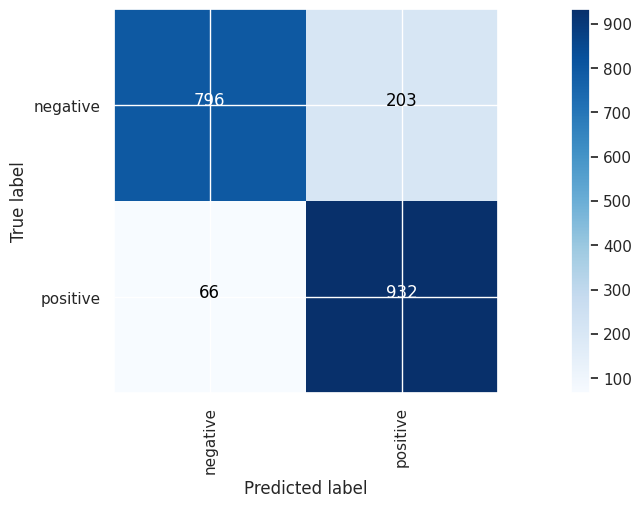

Final Accuracy
0.8652979469203805
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_26 (Dense)            (None, 600, 32)           1632      
                                                                 
 dropout_13 (Dropout)        (None, 600, 32)           0         
                                                                 
 flatten_13 (Flatten)        (None, 19200)             0         
                                                                 
 dense_27 (Dense)            (None, 2)                 38402     
                                                                 
Total params: 1528684 (5

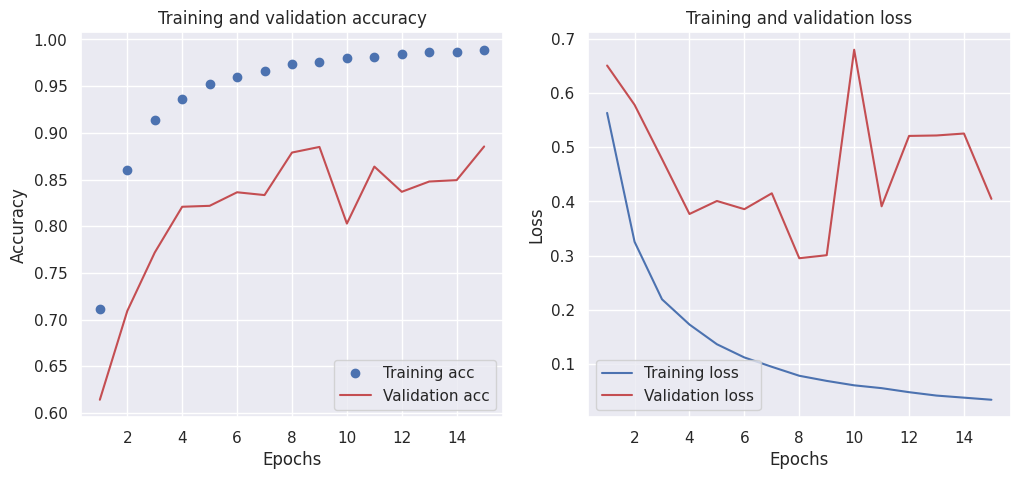

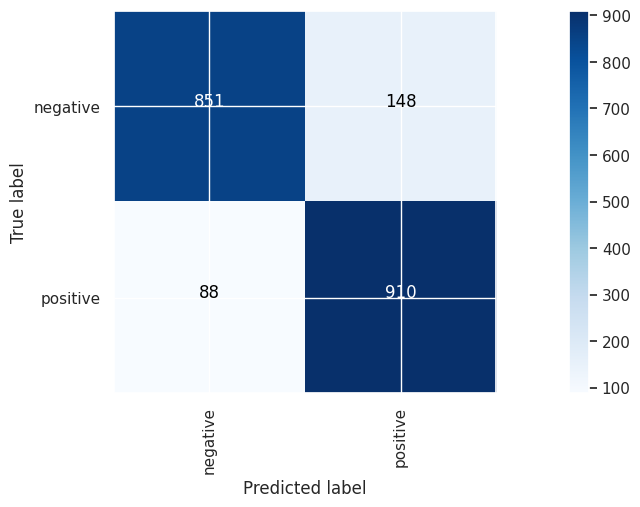

Final Accuracy
0.8818227341011518


In [12]:
# VSM models
results = []
for rep in vsm_model:
    build_exp01("MLP",
                "dense_neurons=[32], dropout_layers=[0.5]", 
                rep, 
                dense_neurons=[32],
                dropout_layers=[0.5], 
                input_shape=(5000,1,))

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp01("MLP",
            "dense_neurons=[32], dropout_layers=[0.5]", 
            embedding_padding, 
            dense_neurons=[32],
            dropout_layers=[0.5], 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp01("MLP",
            "dense_neurons=[32], dropout_layers=[0.5]", 
            embedding_glove, 
            dense_neurons=[32],
            dropout_layers=[0.5], 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_01_4.csv", index=False)

Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_28 (Dense)            (None, 5000, 16)          32        
                                                                 
 dropout_14 (Dropout)        (None, 5000, 16)          0         
                                                                 
 flatten_14 (Flatten)        (None, 80000)             0         
                                                                 
 dense_29 (Dense)            (None, 2)                 160002    
                                                                 
Total params: 160034 (625.13 KB)
Trainable params: 160034 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
25

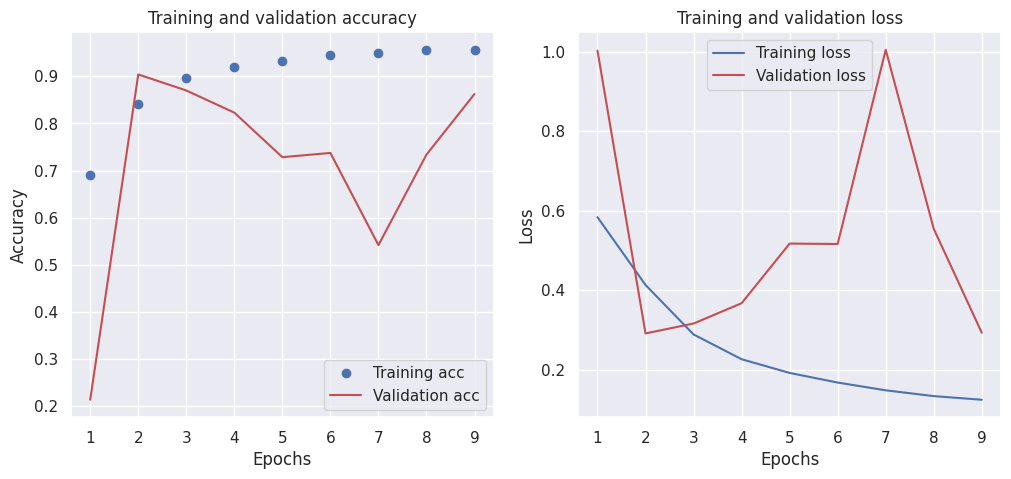

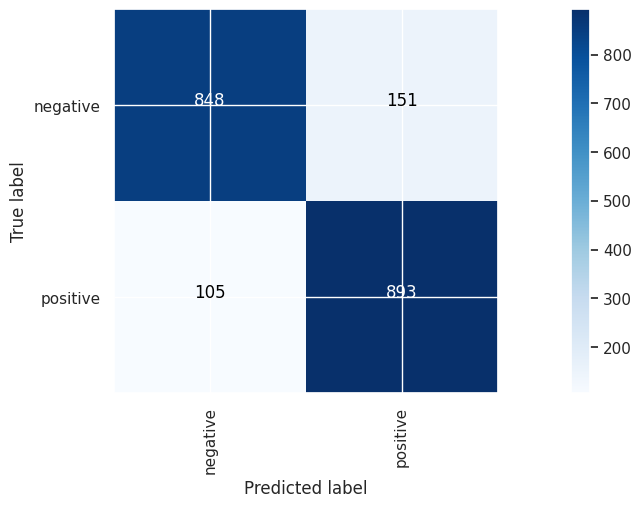

Final Accuracy
0.871807711567351
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_30 (Dense)            (None, 5000, 16)          32        
                                                                 
 dropout_15 (Dropout)        (None, 5000, 16)          0         
                                                                 
 flatten_15 (Flatten)        (None, 80000)             0         
                                                                 
 dense_31 (Dense)            (None, 2)                 160002    
                                                                 
Total params: 160034 (625.13 KB)
Trainable params: 160034 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________

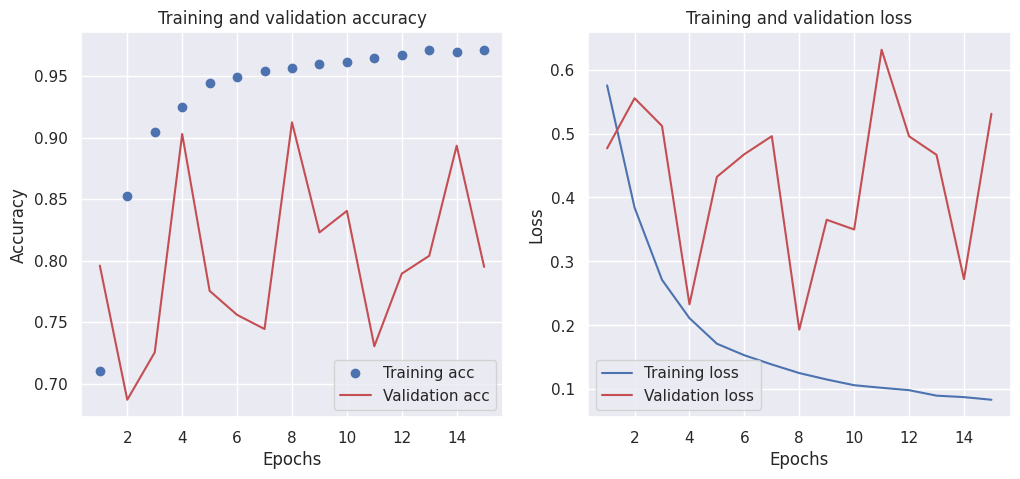

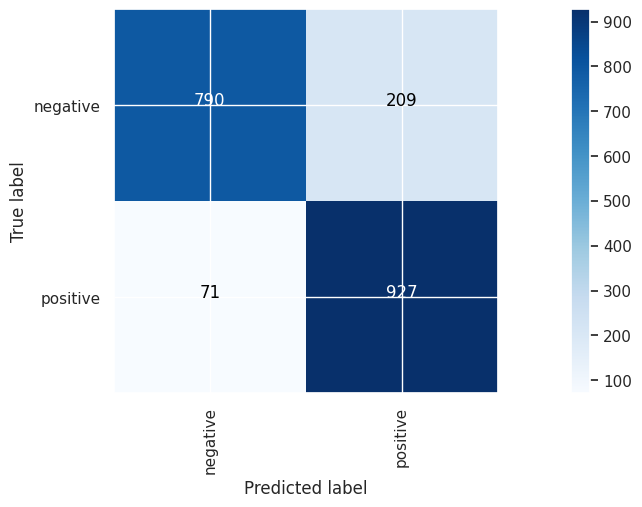

Final Accuracy
0.8597896845267902
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_32 (Dense)            (None, 5000, 16)          32        
                                                                 
 dropout_16 (Dropout)        (None, 5000, 16)          0         
                                                                 
 flatten_16 (Flatten)        (None, 80000)             0         
                                                                 
 dense_33 (Dense)            (None, 2)                 160002    
                                                                 
Total params: 160034 (625.13 KB)
Trainable params: 160034 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________

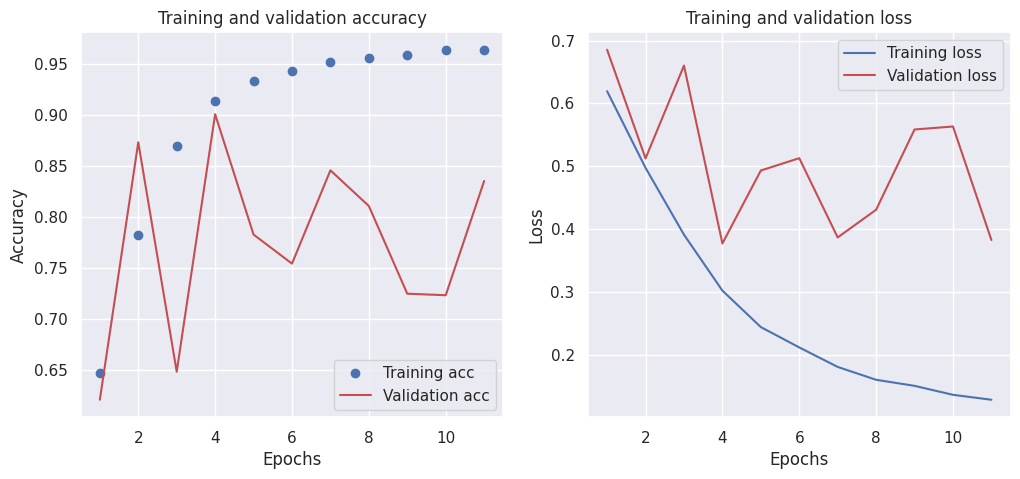

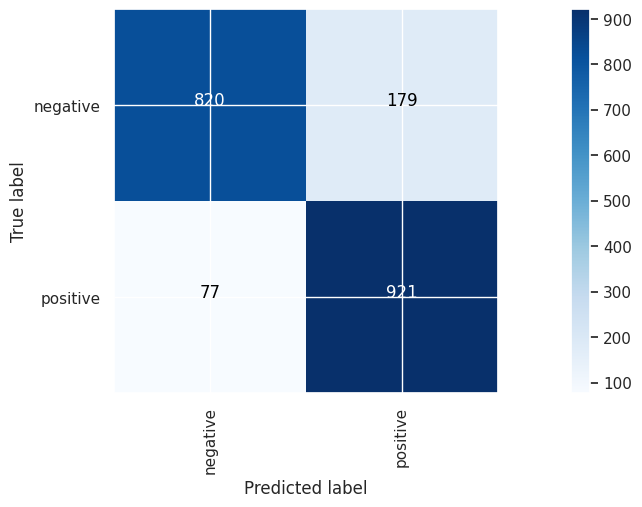

Final Accuracy
0.871807711567351
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_34 (Dense)            (None, 5000, 16)          32        
                                                                 
 dropout_17 (Dropout)        (None, 5000, 16)          0         
                                                                 
 flatten_17 (Flatten)        (None, 80000)             0         
                                                                 
 dense_35 (Dense)            (None, 2)                 160002    
                                                                 
Total params: 160034 (625.13 KB)
Trainable params: 160034 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________

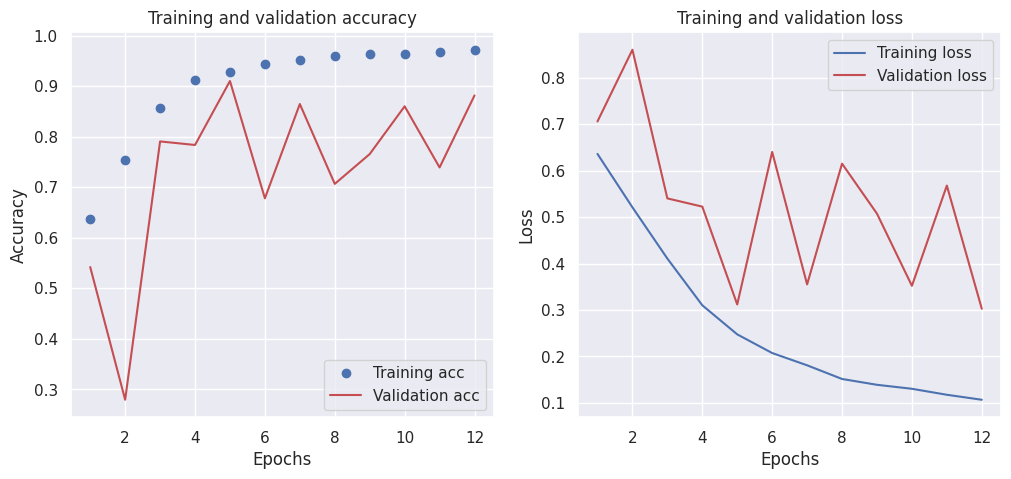

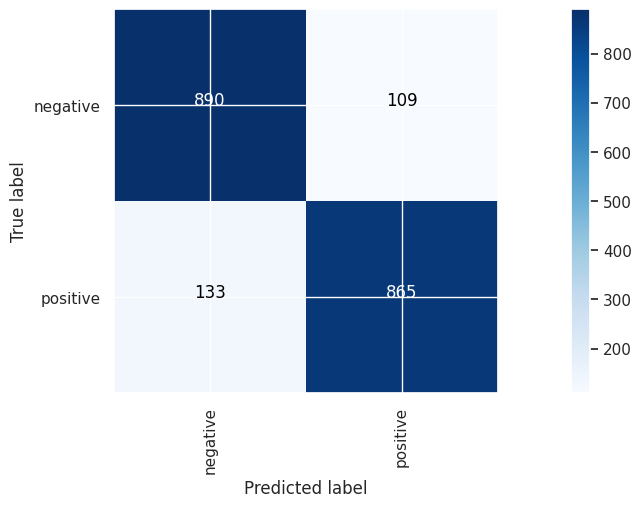

Final Accuracy
0.8788182273410116
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_36 (Dense)            (None, 600, 16)           816       
                                                                 
 dropout_18 (Dropout)        (None, 600, 16)           0         
                                                                 
 flatten_18 (Flatten)        (None, 9600)              0         
                                                                 
 dense_37 (Dense)            (None, 2)                 19202     
                                                                 
Total params: 1508668 (5

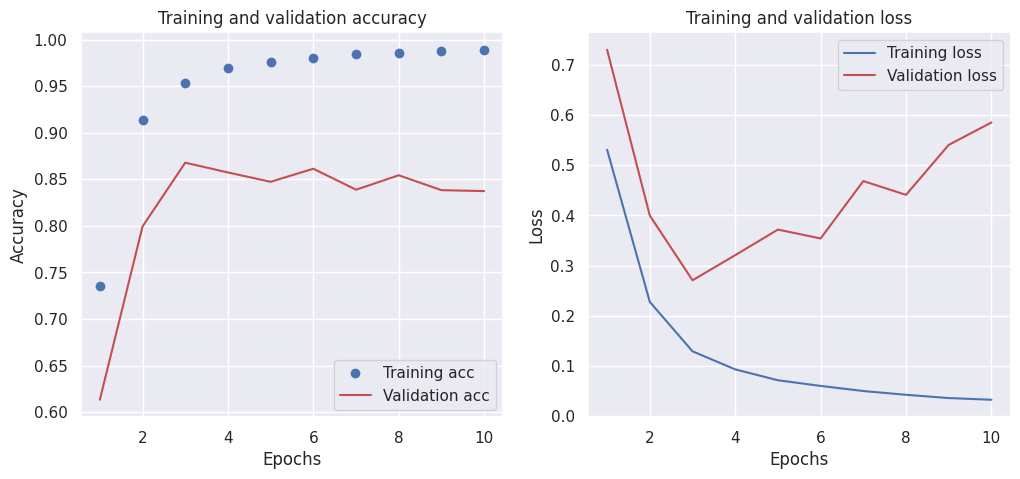

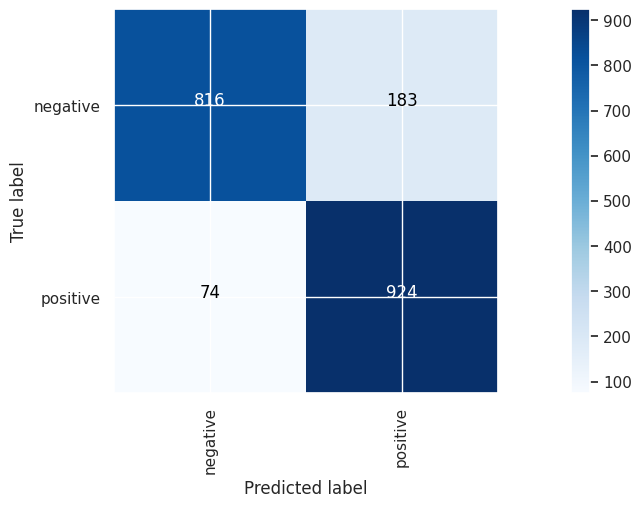

Final Accuracy
0.871306960440661
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_38 (Dense)            (None, 600, 16)           816       
                                                                 
 dropout_19 (Dropout)        (None, 600, 16)           0         
                                                                 
 flatten_19 (Flatten)        (None, 9600)              0         
                                                                 
 dense_39 (Dense)            (None, 2)                 19202     
                                                                 
Total params: 1508668 (5.

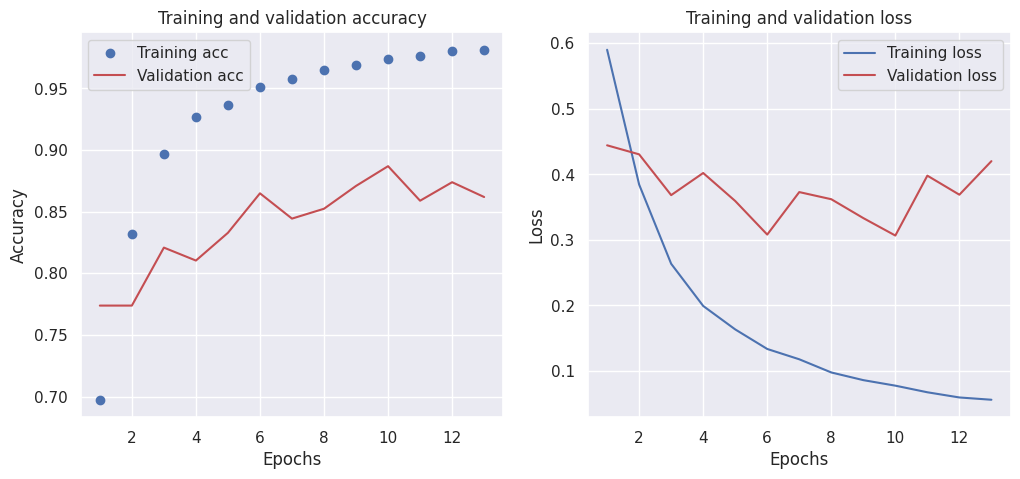

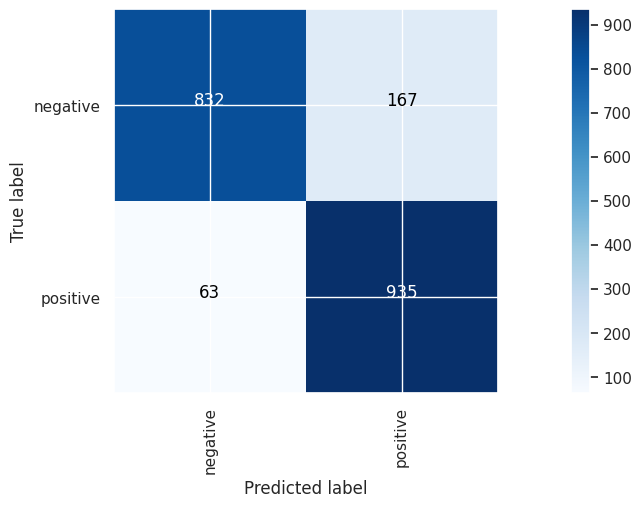

Final Accuracy
0.8848272408612919


In [13]:
# VSM models
results = []
for rep in vsm_model:
    build_exp01("MLP",
                "dense_neurons=[16], dropout_layers=[0.5]", 
                rep, 
                dense_neurons=[16],
                dropout_layers=[0.5], 
                input_shape=(5000,1,))
    
# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp01("MLP",
            "dense_neurons=[16], dropout_layers=[0.5]", 
            embedding_padding, 
            dense_neurons=[16],
            dropout_layers=[0.5], 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp01("MLP",
            "dense_neurons=[16], dropout_layers=[0.5]", 
            embedding_glove, 
            dense_neurons=[16],
            dropout_layers=[0.5], 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_01_5.csv", index=False)

Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_40 (Dense)            (None, 5000, 32)          64        
                                                                 
 dropout_20 (Dropout)        (None, 5000, 32)          0         
                                                                 
 dense_41 (Dense)            (None, 5000, 32)          1056      
                                                                 
 dropout_21 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_20 (Flatten)        (None, 160000)            0         
                                                                 
 dense_42 (Dense)            (None, 2)                 320

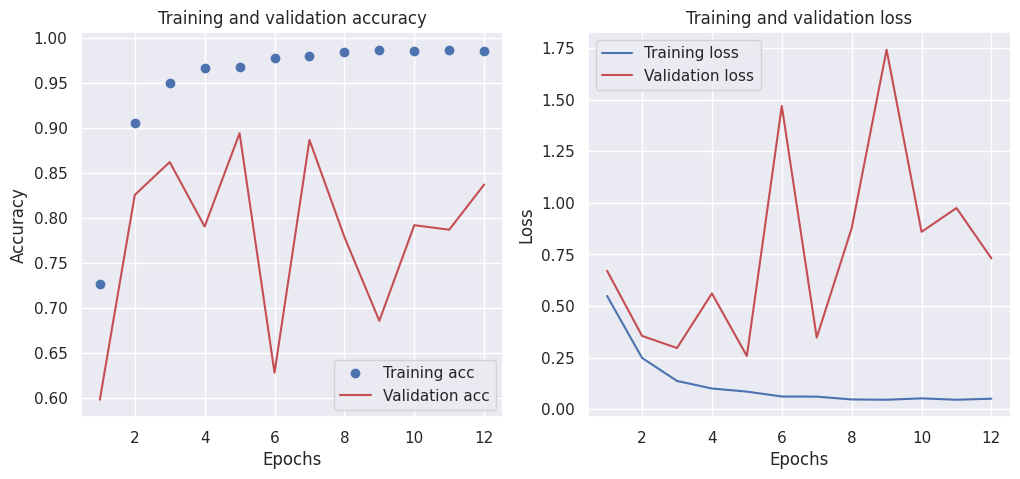

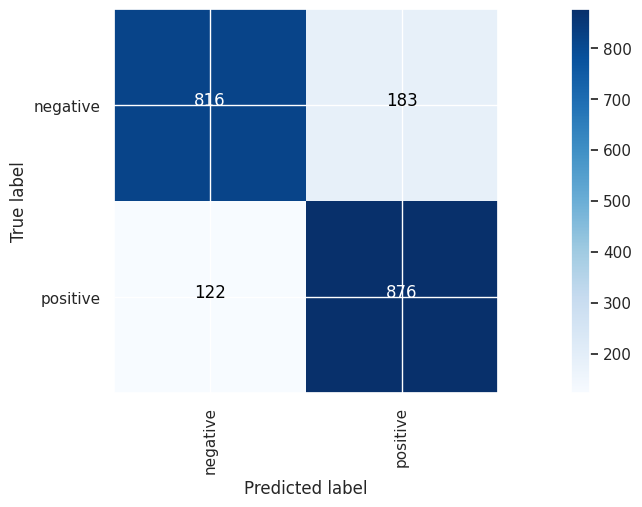

Final Accuracy
0.8472709063595393
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_43 (Dense)            (None, 5000, 32)          64        
                                                                 
 dropout_22 (Dropout)        (None, 5000, 32)          0         
                                                                 
 dense_44 (Dense)            (None, 5000, 32)          1056      
                                                                 
 dropout_23 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_21 (Flatten)        (None, 160000)            0         
                                                                 
 dense_45 (Dense)       

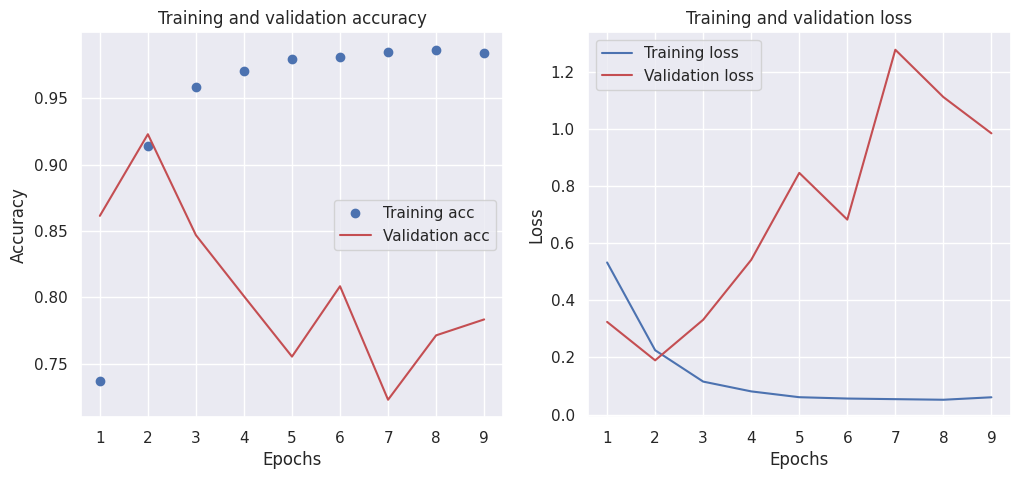

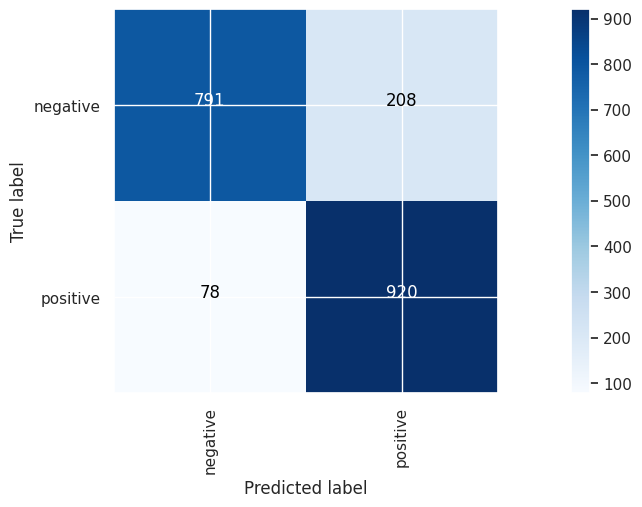

Final Accuracy
0.85678517776665
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_46 (Dense)            (None, 5000, 32)          64        
                                                                 
 dropout_24 (Dropout)        (None, 5000, 32)          0         
                                                                 
 dense_47 (Dense)            (None, 5000, 32)          1056      
                                                                 
 dropout_25 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_22 (Flatten)        (None, 160000)            0         
                                                                 
 dense_48 (Dense)         

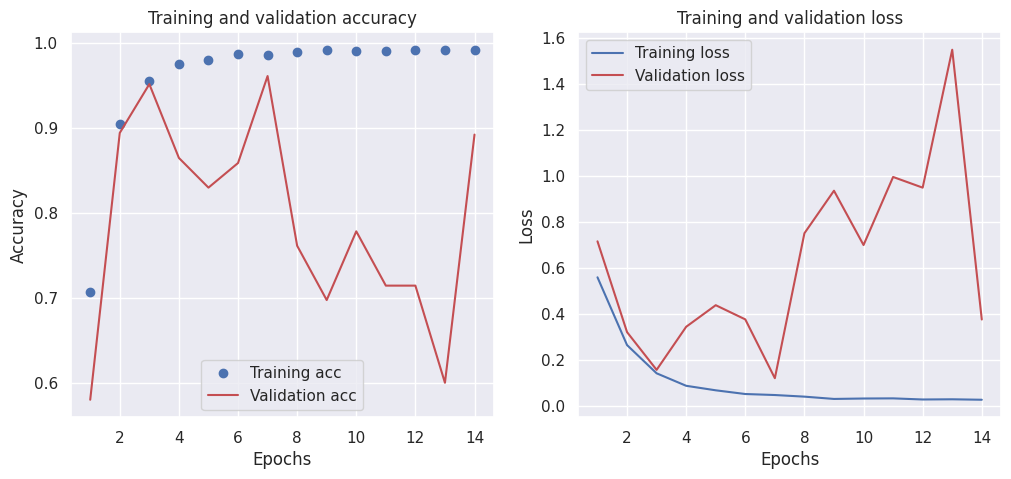

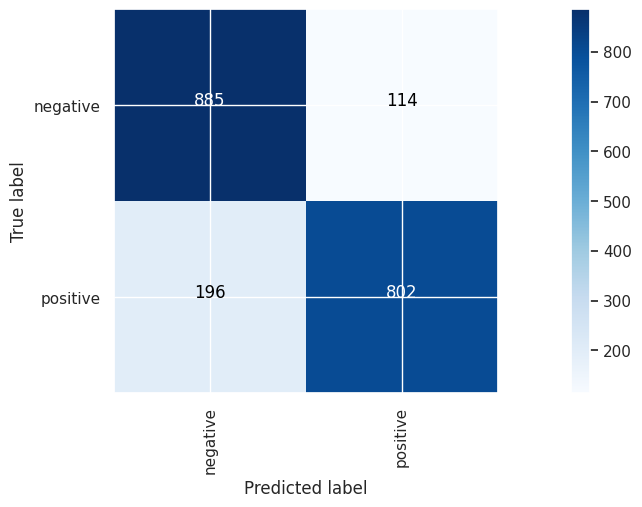

Final Accuracy
0.8447671507260891
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_49 (Dense)            (None, 5000, 32)          64        
                                                                 
 dropout_26 (Dropout)        (None, 5000, 32)          0         
                                                                 
 dense_50 (Dense)            (None, 5000, 32)          1056      
                                                                 
 dropout_27 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_23 (Flatten)        (None, 160000)            0         
                                                                 
 dense_51 (Dense)       

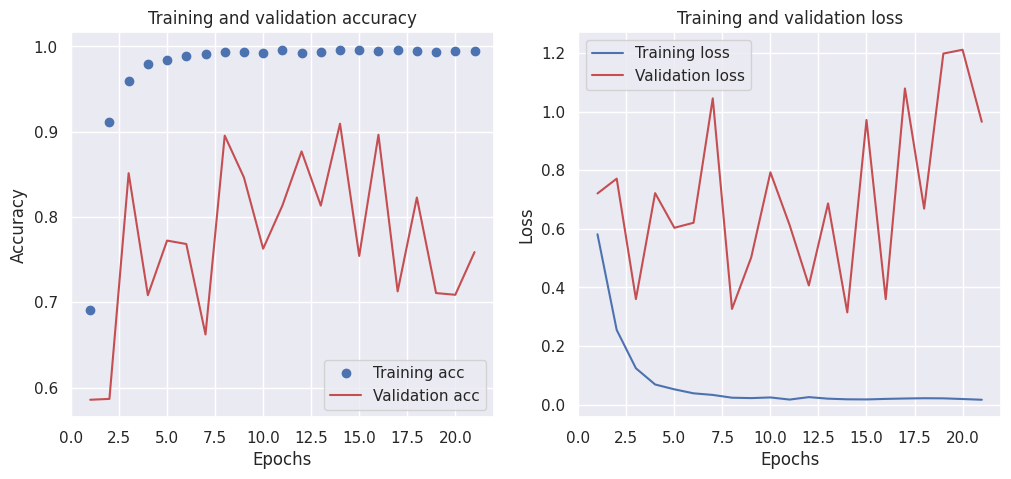

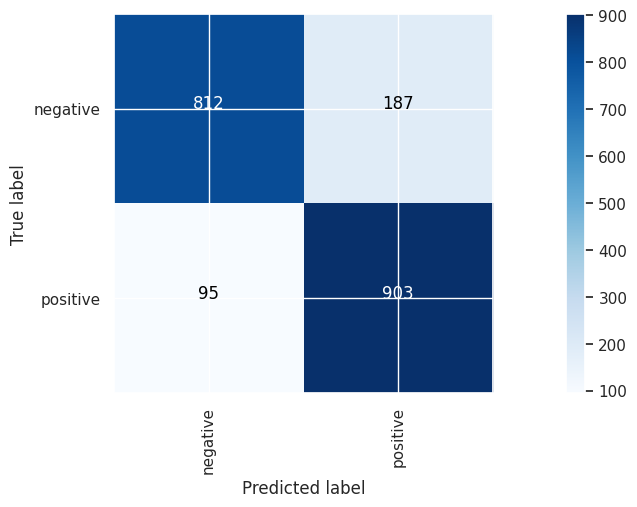

Final Accuracy
0.8587881822734101
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_52 (Dense)            (None, 600, 32)           1632      
                                                                 
 dropout_28 (Dropout)        (None, 600, 32)           0         
                                                                 
 dense_53 (Dense)            (None, 600, 32)           1056      
                                                                 
 dropout_29 (Dropout)        (None, 600, 32)           0         
                                                                 
 flatten_24 (Flatten)   

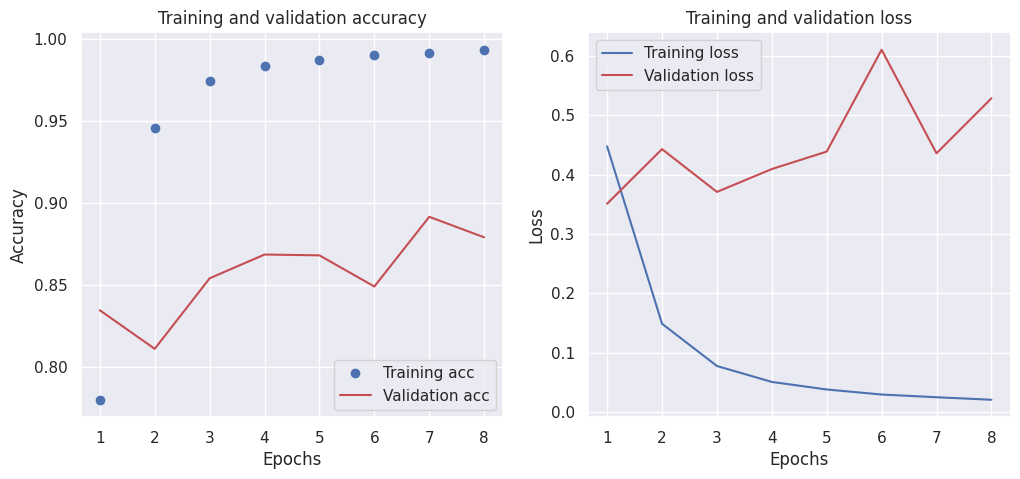

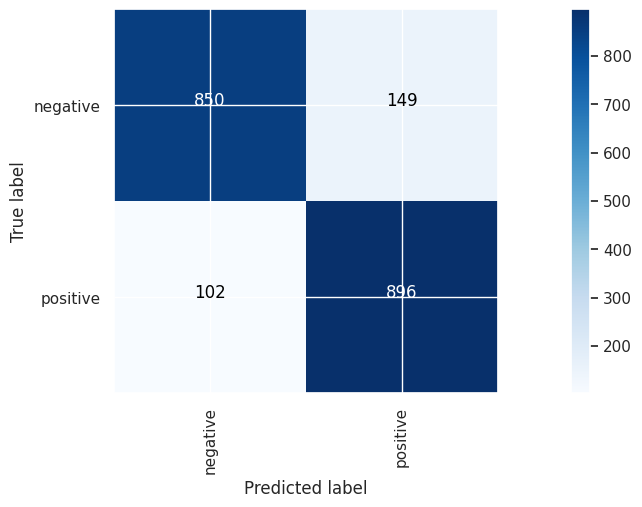

Final Accuracy
0.8743114672008012
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 dense_55 (Dense)            (None, 600, 32)           1632      
                                                                 
 dropout_30 (Dropout)        (None, 600, 32)           0         
                                                                 
 dense_56 (Dense)            (None, 600, 32)           1056      
                                                                 
 dropout_31 (Dropout)        (None, 600, 32)           0         
                                                                 
 flatten_25 (Flatten)   

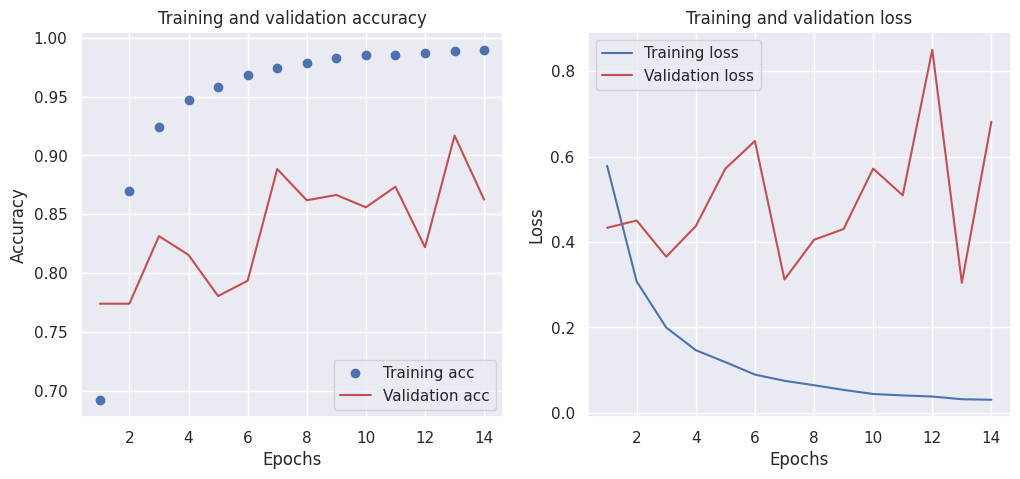

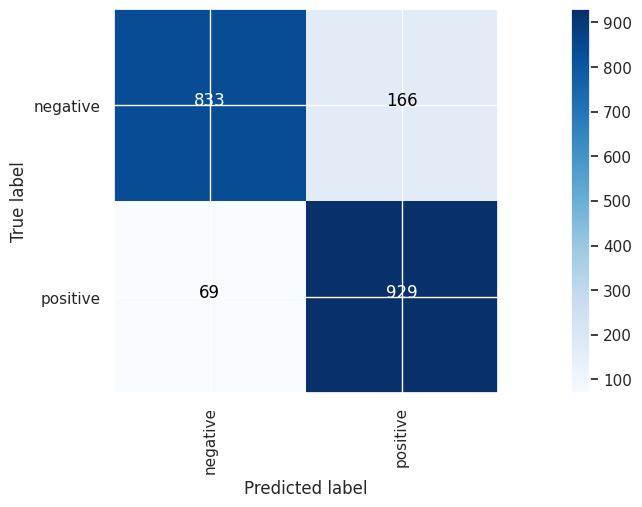

Final Accuracy
0.8823234852278418


In [14]:
# VSM models
results = []
for rep in vsm_model:
    build_exp01("MLP",
                "dense_neurons=[32,32], dropout_layers=[0.2,0.2]", 
                rep, 
                dense_neurons=[32,32],
                dropout_layers=[0.2,0.2], 
                input_shape=(5000,1,))

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp01("MLP",
            "dense_neurons=[32,32], dropout_layers=[0.2,0.2]", 
            embedding_padding, 
            dense_neurons=[32,32],
            dropout_layers=[0.2,0.2], 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp01("MLP",
            "dense_neurons=[32,32], dropout_layers=[0.2,0.2]", 
            embedding_glove, 
            dense_neurons=[32,32],
            dropout_layers=[0.2,0.2], 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_01_6.csv", index=False)

Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_58 (Dense)            (None, 5000, 32)          64        
                                                                 
 dense_59 (Dense)            (None, 5000, 32)          1056      
                                                                 
 dropout_32 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_26 (Flatten)        (None, 160000)            0         
                                                                 
 dense_60 (Dense)            (None, 2)                 320002    
                                                                 
Total params: 321122 (1.22 MB)
Trainable params: 321122 (1

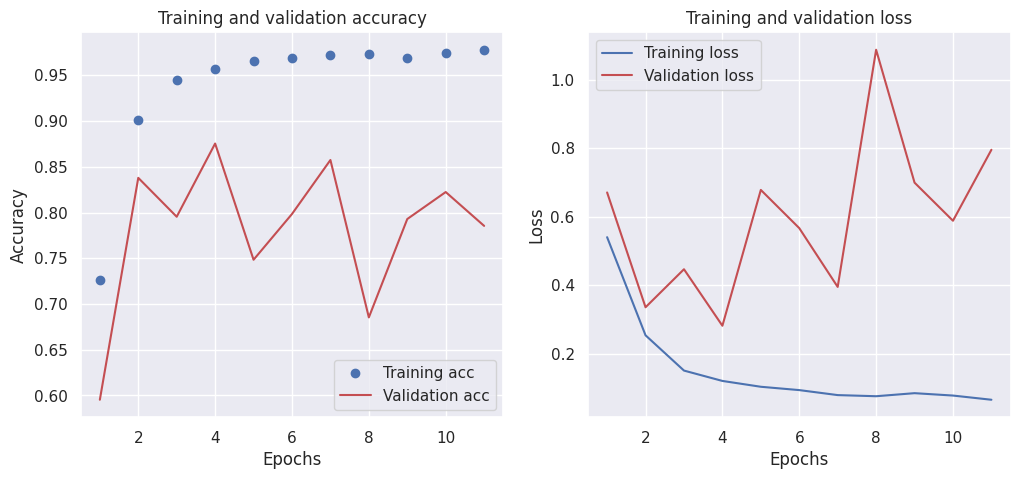

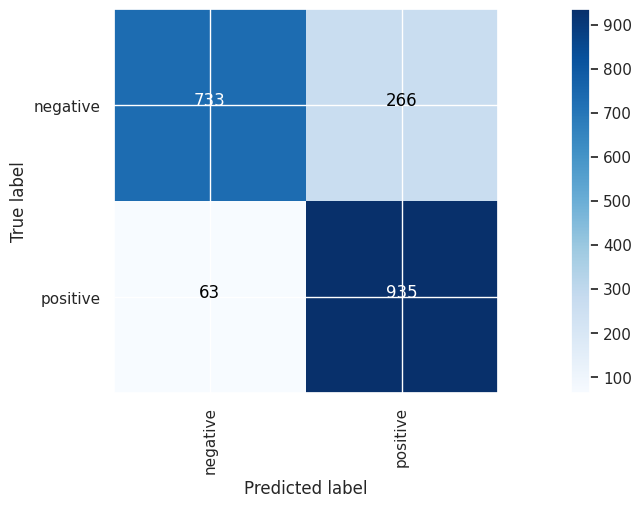

Final Accuracy
0.8352528793189785
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_61 (Dense)            (None, 5000, 32)          64        
                                                                 
 dense_62 (Dense)            (None, 5000, 32)          1056      
                                                                 
 dropout_33 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_27 (Flatten)        (None, 160000)            0         
                                                                 
 dense_63 (Dense)            (None, 2)                 320002    
                                                                 
Total params: 321122 (1.

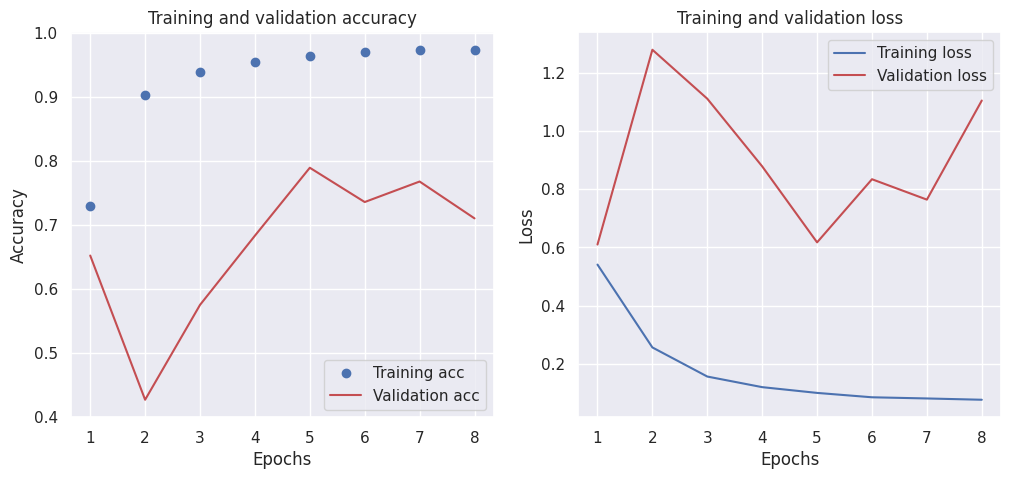

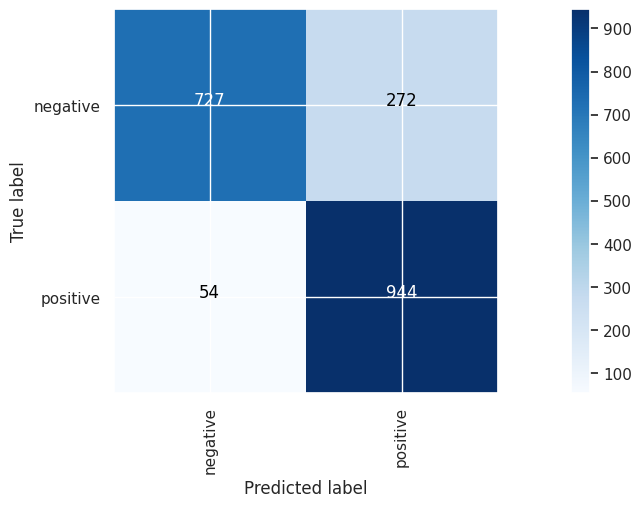

Final Accuracy
0.8367551326990486
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_64 (Dense)            (None, 5000, 32)          64        
                                                                 
 dense_65 (Dense)            (None, 5000, 32)          1056      
                                                                 
 dropout_34 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_28 (Flatten)        (None, 160000)            0         
                                                                 
 dense_66 (Dense)            (None, 2)                 320002    
                                                                 
Total params: 321122 (1.

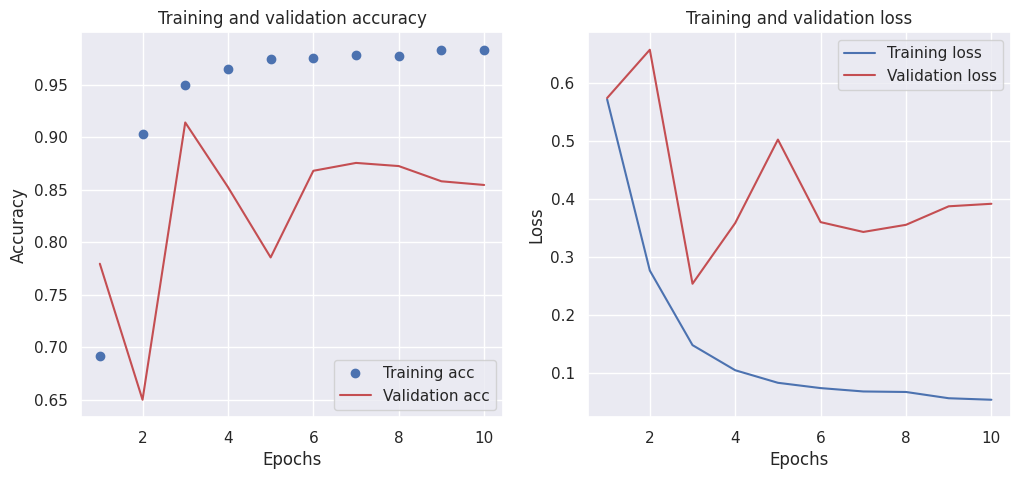

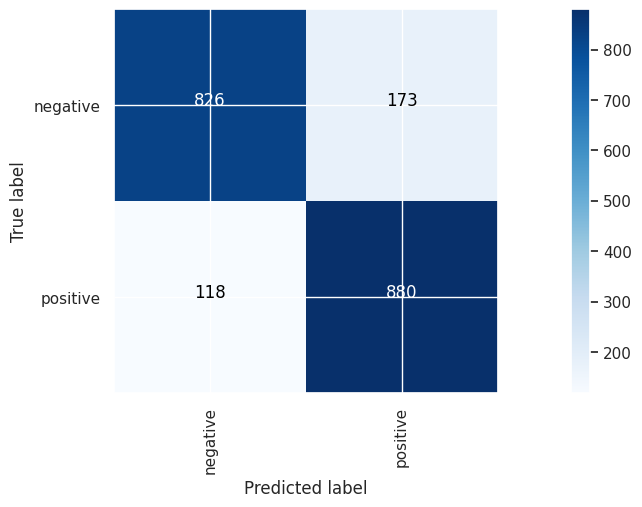

Final Accuracy
0.8542814221331998
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 dense_67 (Dense)            (None, 5000, 32)          64        
                                                                 
 dense_68 (Dense)            (None, 5000, 32)          1056      
                                                                 
 dropout_35 (Dropout)        (None, 5000, 32)          0         
                                                                 
 flatten_29 (Flatten)        (None, 160000)            0         
                                                                 
 dense_69 (Dense)            (None, 2)                 320002    
                                                                 
Total params: 321122 (1.

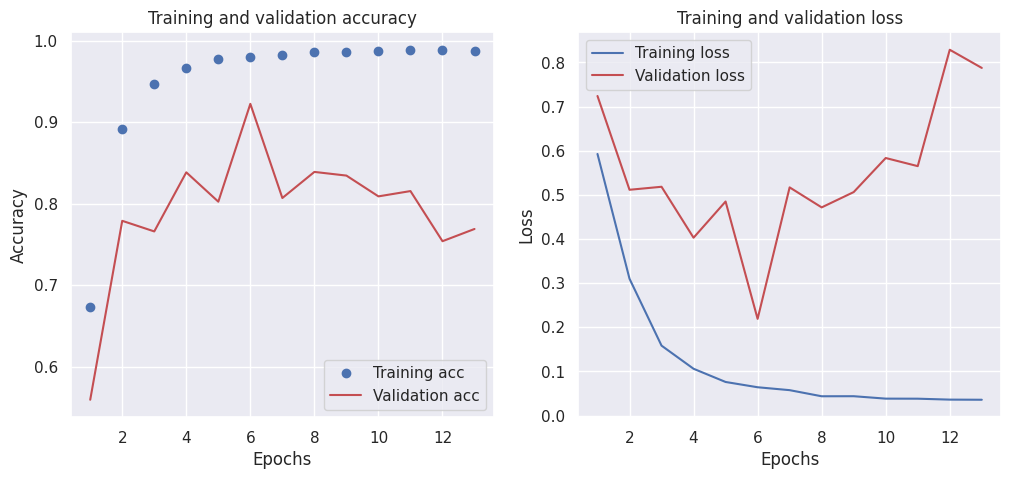

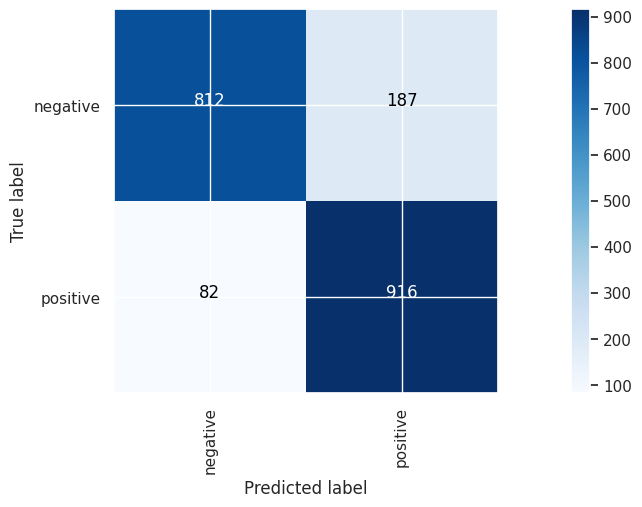

Final Accuracy
0.8652979469203805
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 dense_70 (Dense)            (None, 600, 32)           1632      
                                                                 
 dense_71 (Dense)            (None, 600, 32)           1056      
                                                                 
 dropout_36 (Dropout)        (None, 600, 32)           0         
                                                                 
 flatten_30 (Flatten)        (None, 19200)             0         
                                                                 
 dense_72 (Dense)       

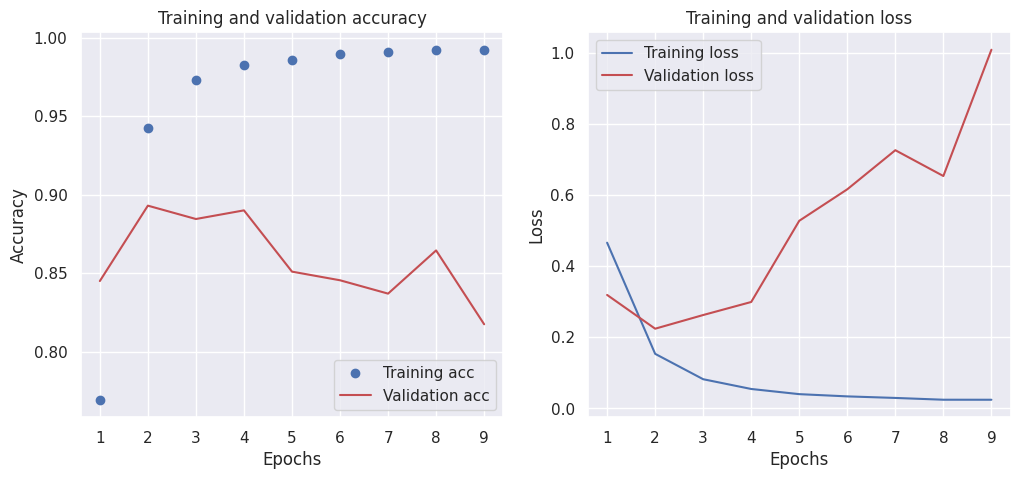

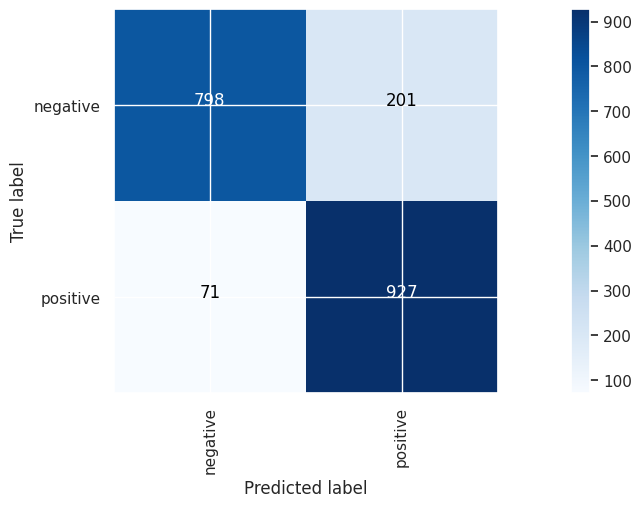

Final Accuracy
0.8637956935403105
Model: "Exp01MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 dense_73 (Dense)            (None, 600, 32)           1632      
                                                                 
 dense_74 (Dense)            (None, 600, 32)           1056      
                                                                 
 dropout_37 (Dropout)        (None, 600, 32)           0         
                                                                 
 flatten_31 (Flatten)        (None, 19200)             0         
                                                                 
 dense_75 (Dense)       

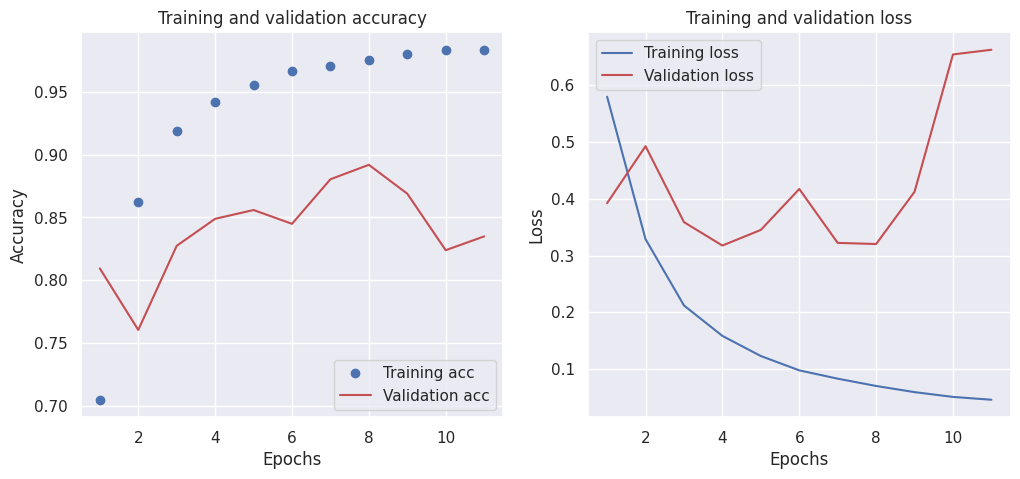

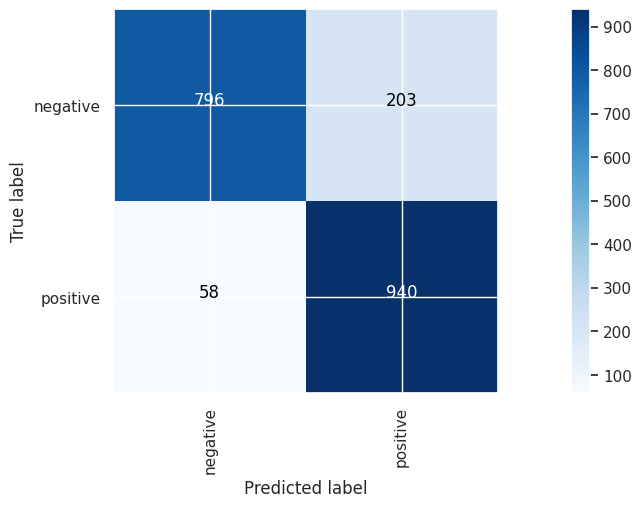

Final Accuracy
0.8693039559339009


In [15]:
# VSM models
results = []
for rep in vsm_model:
    build_exp01("MLP",
                "dense_neurons=[32,32], dropout_layers=[None,0.5]", 
                rep, 
                dense_neurons=[32,32],
                dropout_layers=[None,0.5], 
                input_shape=(5000,1,))

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp01("MLP",
            "dense_neurons=[32,32], dropout_layers=[None,0.5]", 
            embedding_padding, 
            dense_neurons=[32,32],
            dropout_layers=[None,0.5], 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp01("MLP",
            "dense_neurons=[32,32], dropout_layers=[None,0.5]", 
            embedding_glove, 
            dense_neurons=[32,32],
            dropout_layers=[None,0.5], 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_01_7.csv", index=False)

In [13]:
join_csv_for_experiment("01", 7)
pd.read_csv("exp_01.csv").sort_values(by=["accuracy"], ascending=False, ignore_index=True)[["classifier", "rep.model", "accuracy"]]

classifier  \
0          Exp01MLP dense_neurons=[128], dropout_layers=[0.5]   
1           Exp01MLP dense_neurons=[16], dropout_layers=[0.5]   
2           Exp01MLP dense_neurons=[64], dropout_layers=[0.5]   
3    Exp01MLP dense_neurons=[32,32], dropout_layers=[0.2,0.2]   
4           Exp01MLP dense_neurons=[32], dropout_layers=[0.5]   
5           Exp01MLP dense_neurons=[64], dropout_layers=[0.5]   
6           Exp01MLP dense_neurons=[16], dropout_layers=[0.5]   
7           Exp01MLP dense_neurons=[32], dropout_layers=[0.5]   
8           Exp01MLP dense_neurons=[64], dropout_layers=[0.5]   
9          Exp01MLP dense_neurons=[128], dropout_layers=[0.5]   
10   Exp01MLP dense_neurons=[32,32], dropout_layers=[0.2,0.2]   
11          Exp01MLP dense_neurons=[16], dropout_layers=[0.5]   
12          Exp01MLP dense_neurons=[64], dropout_layers=[0.5]   
13          Exp01MLP dense_neurons=[16], dropout_layers=[0.5]   
14          Exp01MLP dense_neurons=[16], dropout_layers=[0.5]   
15  Exp01MLP dense_neurons=[32,32], dropout_layers=[None,0.5]   
16          Exp01MLP dense_neurons=[32], dropout_layers=[0.5]   
17          Exp01MLP dense_neurons=[32], dropout_layers=[0.5]   
18  Exp01MLP dense_neurons=[32,32], dropout_layers=[None,0.5]   
19  Exp01MLP dense_neurons=[32,32], dropout_layers=[None,0.5]   
20          Exp01MLP dense_neurons=[32], dropout_layers=[0.5]   
21          Exp01MLP dense_neurons=[16], dropout_layers=[0.5]   
22   Exp01MLP dense_neurons=[32,32], dropout_layers=[0.2,0.2]   
23   Exp01MLP dense_neurons=[32,32], dropout_layers=[0.2,0.2]   
24          Exp01MLP dense_neurons=[64], dropout_layers=[0.5]   
25  Exp01MLP dense_neurons=[32,32], dropout_layers=[None,0.5]   
26         Exp01MLP dense_neurons=[128], dropout_layers=[0.5]   
27   Exp01MLP dense_neurons=[32,32], dropout_layers=[0.2,0.2]   
28   Exp01MLP dense_neurons=[32,32], dropout_layers=[0.2,0.2]   
29  Exp01MLP dense_neurons=[32,32], dropout_layers=[None,0.5]   
30  Exp01MLP dense_neurons=[32,32], dropout_layers=[None,0.5]   
31         Exp01MLP dense_neurons=[128], dropout_layers=[0.5]   
32         Exp01MLP dense_neurons=[128], dropout_layers=[0.5]   
33          Exp01MLP dense_neurons=[64], dropout_layers=[0.5]   
34          Exp01MLP dense_neurons=[32], dropout_layers=[0.5]   

                                                                             rep.model  \
0                                                            Word embedding with GloVe   
1                                                            Word embedding with GloVe   
2                                                            Word embedding with GloVe   
3                                                            Word embedding with GloVe   
4                                                            Word embedding with GloVe   
5                   Word embedding: tokenizando el texto en secuencias y pad_sequences   
6    VSM + pesado TF-IDF + rango de n-grams [1 y 2] + redimensionamiento por SVD (LSI)   
7    VSM + pesado TF-IDF + rango de n-grams [1 y 2] + redimensionamiento por SVD (LSI)   
8    VSM + pesado TF-IDF + rango de n-grams [1 y 2] + redimensionamiento por SVD (LSI)   
9    VSM + pesado TF-IDF + rango de n-grams [1 y 2] + redimensionamiento por SVD (LSI)   
10                  Word embedding: tokenizando el texto en secuencias y pad_sequences   
11                             VSM + pesado binario + redimensionamiento por SVD (LSI)   
12                              VSM + pesado TF-IDF + redimensionamiento por SVD (LSI)   
13                              VSM + pesado TF-IDF + redimensionamiento por SVD (LSI)   
14                  Word embedding: tokenizando el texto en secuencias y pad_sequences   
15                                                           Word embedding with GloVe   
16                  Word embedding: tokenizando el texto en secuencias y pad_sequences   
17                              VSM + pesado TF-IDF + redimensionamiento por SVD (LSI)   
